# Statistical Foundations for Factor Model Analysis

## Inference, the Central Limit Theorem, and Nonparametric Robust Standard Errors

This notebook is a **prerequisite** for the [Fama-French 3-Factor Tutorial](03_Fama_French_3Factor.ipynb) and the [Advanced Factor Tutorial](04_Advanced_Factor_Models.ipynb). It develops the statistical concepts those notebooks rely on — with small, hand-checkable examples so that every formula can be verified without a computer.

### What We'll Cover

1. **Descriptive Statistics Refresher** — Mean, variance, covariance with a tiny dataset
2. **Random Variables & Expectation** — The population vs. sample distinction
3. **The Central Limit Theorem (CLT)** — Why it is the single most important result in applied statistics
4. **Hypothesis Testing and the CLT** — t-statistics, p-values, confidence intervals, and why the normal approximation works
5. **Linear Regression and OLS** — From scalar formulas to matrix notation, with hand-checkable examples
6. **Nonparametric Robust Inference** — The sandwich formula, the CLT connection, and HC standard errors
7. **Newey-West HAC Standard Errors** — Full derivation with a hand-checkable example
8. **Newey-West on a Realistic Sample** — Simulation with heteroscedasticity and autocorrelation
9. **Putting It All Together** — From CLT to Newey-West to the standard normal p-value
10. **Summary** — Quick-reference tables and connection to the Fama-French tutorials

### Prerequisites

- **Probability theory** — random variables, expectation, variance, the law of large numbers
- **Basic statistics** — hypothesis testing, confidence intervals, the normal distribution
- **Linear algebra essentials** — matrix multiplication, transpose, inverse (used in the OLS sections)
- **Basic familiarity with Python** (for the verification code; the math stands alone)

### Philosophy

Every result in this notebook is **demonstrated on data small enough to check by hand** (typically 5–8 observations). The code cells verify the hand calculations — they never replace them. We encourage you to work through the arithmetic with pen and paper before running the code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')

np.random.seed(42)
print("Libraries loaded.")

Libraries loaded.


---

## Section 1: Descriptive Statistics — A Hand-Checkable Example

We start with a dataset small enough to compute everything on paper. Suppose we observe 5 monthly excess returns (in percent):

$$x = (2, \;-1, \;3, \;0, \;1)$$

### 1.1 Sample Mean

$$\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i = \frac{2 + (-1) + 3 + 0 + 1}{5} = \frac{5}{5} = 1.0$$

### 1.2 Sample Variance (with Bessel's correction)

$$s^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2$$

The deviations from the mean are:

| $i$ | $x_i$ | $x_i - \bar{x}$ | $(x_i - \bar{x})^2$ |
|-----|--------|------------------|----------------------|
| 1   | 2      | 1                | 1                    |
| 2   | −1     | −2               | 4                    |
| 3   | 3      | 2                | 4                    |
| 4   | 0      | −1               | 1                    |
| 5   | 1      | 0                | 0                    |
|     |        | **Sum**          | **10**               |

$$s^2 = \frac{10}{5-1} = \frac{10}{4} = 2.5$$

$$s = \sqrt{2.5} \approx 1.5811$$

### 1.3 Why $n - 1$? (Bessel's Correction)

If we knew the true population mean $\mu$, we would divide by $n$. But we estimated $\mu$ from the same data (using $\bar{x}$), which "uses up" one degree of freedom. Dividing by $n - 1$ corrects for this, making $s^2$ an **unbiased** estimator of the population variance:

$$E[s^2] = \sigma^2$$

With only $n = 5$ observations, the difference between dividing by 4 vs. 5 is 25% — far from negligible!

In [2]:
# ============================================================================
# Section 1: Verify hand calculations
# ============================================================================

x = np.array([2, -1, 3, 0, 1], dtype=float)
n = len(x)

mean = x.sum() / n
var = ((x - mean)**2).sum() / (n - 1)
std = np.sqrt(var)

print("Hand-checkable dataset: x =", x)
print(f"\nSample size n = {n}")
print(f"Sum = {x.sum()}")
print(f"Mean = {x.sum()}/{n} = {mean}")
print(f"\nDeviations from mean: {x - mean}")
print(f"Squared deviations:   {(x - mean)**2}")
print(f"Sum of squared devs:  {((x - mean)**2).sum()}")
print(f"\nSample variance s² = {((x - mean)**2).sum()}/{n-1} = {var}")
print(f"Sample std dev s   = √{var} = {std:.4f}")

# Verify against numpy (which uses n-1 by default in pandas, but n in numpy)
print(f"\nVerification:")
print(f"  np.mean(x) = {np.mean(x)}")
print(f"  np.var(x, ddof=1) = {np.var(x, ddof=1)}")  # ddof=1 => Bessel's
print(f"  np.std(x, ddof=1) = {np.std(x, ddof=1):.4f}")

Hand-checkable dataset: x = [ 2. -1.  3.  0.  1.]

Sample size n = 5
Sum = 5.0
Mean = 5.0/5 = 1.0

Deviations from mean: [ 1. -2.  2. -1.  0.]
Squared deviations:   [1. 4. 4. 1. 0.]
Sum of squared devs:  10.0

Sample variance s² = 10.0/4 = 2.5
Sample std dev s   = √2.5 = 1.5811

Verification:
  np.mean(x) = 1.0
  np.var(x, ddof=1) = 2.5
  np.std(x, ddof=1) = 1.5811


### 1.4 Covariance and Correlation (Two Variables)

Now suppose we have a second variable — say, the market excess return for the same 5 months:

$$y = (3, \;-2, \;4, \;1, \;0)$$

$$\bar{y} = \frac{3 + (-2) + 4 + 1 + 0}{5} = \frac{6}{5} = 1.2$$

**Sample covariance:**

$$s_{xy} = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

| $i$ | $x_i - \bar{x}$ | $y_i - \bar{y}$ | Product |
|-----|------------------|------------------|---------|
| 1   | 1                | 1.8              | 1.8     |
| 2   | −2               | −3.2             | 6.4     |
| 3   | 2                | 2.8              | 5.6     |
| 4   | −1               | −0.2             | 0.2     |
| 5   | 0                | −1.2             | 0.0     |
|     |                  | **Sum**          | **14.0**|

$$s_{xy} = \frac{14.0}{4} = 3.5$$

**Sample correlation:**

$$r_{xy} = \frac{s_{xy}}{s_x \cdot s_y}$$

We already know $s_x = \sqrt{2.5}$. For $y$: the squared deviations are $1.8^2 + 3.2^2 + 2.8^2 + 0.2^2 + 1.2^2 = 3.24 + 10.24 + 7.84 + 0.04 + 1.44 = 22.80$, so $s_y^2 = 22.80/4 = 5.70$ and $s_y = \sqrt{5.70} \approx 2.3875$.

$$r_{xy} = \frac{3.5}{\sqrt{2.5} \times \sqrt{5.70}} = \frac{3.5}{1.5811 \times 2.3875} \approx \frac{3.5}{3.7749} \approx 0.9272$$

This strong positive correlation ($\approx 0.93$) means $x$ and $y$ move together closely.

In [3]:
# ============================================================================
# Verify covariance and correlation
# ============================================================================

y = np.array([3, -2, 4, 1, 0], dtype=float)
y_mean = y.mean()
s_y2 = np.var(y, ddof=1)
s_y = np.std(y, ddof=1)

cov_xy = ((x - mean) * (y - y_mean)).sum() / (n - 1)
corr_xy = cov_xy / (std * s_y)

print(f"y = {y}")
print(f"ȳ = {y_mean}")
print(f"s_y² = {s_y2:.2f},  s_y = {s_y:.4f}")
print(f"\nProducts (x_i - x̄)(y_i - ȳ): {(x - mean) * (y - y_mean)}")
print(f"Sum of products: {((x - mean) * (y - y_mean)).sum()}")
print(f"Covariance s_xy = {cov_xy}")
print(f"Correlation r_xy = {cov_xy} / ({std:.4f} × {s_y:.4f}) = {corr_xy:.4f}")
print(f"\nVerification: np.corrcoef(x, y)[0,1] = {np.corrcoef(x, y)[0, 1]:.4f}")

y = [ 3. -2.  4.  1.  0.]
ȳ = 1.2
s_y² = 5.70,  s_y = 2.3875

Products (x_i - x̄)(y_i - ȳ): [ 1.8  6.4  5.6  0.2 -0. ]
Sum of products: 14.0
Covariance s_xy = 3.5
Correlation r_xy = 3.5 / (1.5811 × 2.3875) = 0.9272

Verification: np.corrcoef(x, y)[0,1] = 0.9272


---

## Section 2: Random Variables, Expectation, and the Population–Sample Distinction

### 2.1 Population vs. Sample

A crucial distinction underlies all of statistics:

- The **population** is the entire (usually infinite or very large) set of possible outcomes. For example, "all possible monthly returns that SPY could ever produce."
- A **sample** is a finite collection of observations drawn from the population. For example, "the 168 monthly returns we actually observed from 2010–2023."

We use sample statistics ($\bar{x}$, $s^2$, etc.) to **estimate** population parameters ($\mu$, $\sigma^2$, etc.). The sample mean $\bar{x}$ is our best guess of the true mean $\mu$, but it comes with **uncertainty** because different samples would give different $\bar{x}$ values.

### 2.2 The Standard Error of the Mean

If $X_1, X_2, \ldots, X_n$ are independent draws from a population with mean $\mu$ and variance $\sigma^2$, then the sample mean

$$\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i$$

has:

$$E[\bar{X}] = \mu \qquad \text{Var}(\bar{X}) = \frac{\sigma^2}{n}$$

> **Why $n$ and not $n - 1$ here?** In Section 1.3 we used Bessel's correction ($n - 1$) when *estimating* the population variance $\sigma^2$ from a sample — that corrects for the bias introduced by using $\bar{x}$ in place of the unknown $\mu$. Here the situation is different: we are not estimating anything. The formula $\text{Var}(\bar{X}) = \sigma^2 / n$ is an exact algebraic result that follows directly from the properties of variance. Since the $X_i$ are independent, $\text{Var}\!\left(\sum X_i\right) = \sum \text{Var}(X_i) = n\sigma^2$, and dividing a random variable by $n$ scales its variance by $1/n^2$, giving $\text{Var}(\bar{X}) = n\sigma^2 / n^2 = \sigma^2 / n$. The $n$ here simply counts how many observations are being averaged — it has nothing to do with degrees of freedom or bias correction.

The **standard error of the mean** is therefore:

$$\text{SE}(\bar{X}) = \frac{\sigma}{\sqrt{n}}$$

In practice $\sigma$ is unknown, so we replace it with the sample standard deviation $s$ (computed with the Bessel-corrected $n - 1$ denominator from Section 1.2). Note that the $n - 1$ inside $s$ and the $n$ inside $\sqrt{n}$ play completely different roles: $n - 1$ corrects the bias when *estimating the variance*, while $n$ reflects the *number of observations being averaged*. The estimated standard error is:

$$\widehat{\text{SE}}(\bar{X}) = \frac{s}{\sqrt{n}}$$

**Hand calculation** with our data ($\bar{x} = 1$, $s = \sqrt{2.5}$, $n = 5$):

$$\widehat{\text{SE}} = \frac{\sqrt{2.5}}{\sqrt{5}} = \sqrt{\frac{2.5}{5}} = \sqrt{0.5} \approx 0.7071$$

This tells us: "If we repeatedly drew samples of size 5 from this population and computed the mean each time, those means would have a standard deviation of about 0.71."

In [4]:
# ============================================================================
# Standard error of the mean — hand calculation verification
# ============================================================================

se_mean = std / np.sqrt(n)
print(f"s = {std:.4f}")
print(f"n = {n}")
print(f"SE(x̄) = s / √n = {std:.4f} / √{n} = {se_mean:.4f}")
print(f"Verification: √(s²/n) = √({var}/{n}) = √{var/n:.4f} = {np.sqrt(var/n):.4f}")

s = 1.5811
n = 5
SE(x̄) = s / √n = 1.5811 / √5 = 0.7071
Verification: √(s²/n) = √(2.5/5) = √0.5000 = 0.7071


---

## Section 3: The Central Limit Theorem — The Engine of Inference

The CLT is the single most important result in statistics. It is the reason we can do hypothesis testing, build confidence intervals, and compute p-values. In this section we state the classical version first, then progressively relax its assumptions toward versions that actually apply to financial time series. By the end, you will understand exactly which CLT variant underwrites the **Newey-West standard errors** used throughout the Fama-French tutorials.

> **Reading guide.** Sections 3.1–3.2 (classical CLT) and Section 3.7 (visual demo) are essential for everyone. Sections 3.3–3.5 develop the theoretical machinery that justifies Newey-West for time-series data — they can be skimmed on a first reading and revisited after working through Section 7.

> **What are Newey-West standard errors?** In short, they are a method for computing standard errors that remain valid even when the data are serially correlated and/or heteroscedastic — two features that are ubiquitous in financial time series. Where ordinary standard errors assume each observation is independent, Newey-West standard errors account for the fact that nearby observations may be correlated, producing wider (and more honest) confidence intervals. We develop the full theory and a hand-checkable example in **Section 7**.

### 3.1 Version 1: The Classical CLT (Lindeberg-Lévy)

**Theorem.** Let $X_1, X_2, \ldots, X_n$ be **independent and identically distributed** (i.i.d.) random variables with mean $\mu$ and finite variance $\sigma^2 > 0$. Then as $n \to \infty$:

$$\frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0, 1)$$

In words: **the standardized sample mean converges in distribution to a standard normal**, regardless of the shape of the underlying distribution.

**Assumptions:** (1) identical distributions, (2) independence, (3) finite variance.

**What this buys us:** We can compute the distribution of $\bar{X}_n$ without knowing the shape of the $X_i$. This is extraordinary — we need *no parametric model* for the data.

**Relevance for finance:** If monthly returns were truly i.i.d. (same distribution every month, no dependence across time), this version would be all we need. But they are not — so we need to relax the assumptions.

### 3.2 Why This Is Revolutionary

The CLT tells us something extraordinary:

- The $X_i$ might follow **any** distribution — uniform, exponential, chi-squared, a bizarre bimodal shape, anything with finite variance.
- Yet the **average** of many such observations will be approximately normal.
- The approximation improves as $n$ grows.

This is why the normal distribution appears everywhere in statistics: **it governs the behavior of averages and sums**, not necessarily of individual observations.

### 3.3 Version 2: Dropping "Identical" — The Lindeberg-Feller CLT

**The problem with "identically distributed."** In a regression $y_i = \alpha + \beta x_i + \epsilon_i$, the coefficient estimator $\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ is a *weighted* average of the $y_i$ — where the weights depend on the $x_i$ values and differ across observations. Even if the errors $\epsilon_i$ are i.i.d., the *weighted* terms are not identically distributed. The classical CLT does not directly apply.

**The solution.** The Lindeberg-Feller CLT drops the "identically distributed" requirement:

**Theorem (Lindeberg-Feller).** Let $X_1, \ldots, X_n$ be **independent** (but *not* necessarily identically distributed) random variables with $E[X_i] = \mu_i$ and $\text{Var}(X_i) = \sigma_i^2$. If no single observation dominates the total variance (the *Lindeberg condition*), then:

$$\frac{\sum_{i=1}^n (X_i - \mu_i)}{\sqrt{\sum_{i=1}^n \sigma_i^2}} \xrightarrow{d} \mathcal{N}(0, 1)$$

**Assumptions:** (1) independence, (2) finite variances, (3) no single term dominates.

**What this buys us:** Regression coefficients $\hat{\beta}$ are asymptotically normal even when the regressors $x_i$ take different values across observations. This is why OLS inference works even for regression (not just sample means).

**Relevance for finance:** This handles the "weighted average" structure of $\hat{\beta}$, but still requires independence — which financial time series violate.

### 3.4 Version 3: Dropping "Independent" (Partially) — The Martingale Difference CLT

**The problem with "independent."** Monthly stock returns exhibit **volatility clustering** — periods of high volatility (like 2008–2009 or March 2020) alternate with calm periods. Even if returns themselves are nearly unpredictable (weak autocorrelation), they are *not independent*, because knowing yesterday's return magnitude tells you something about today's volatility.

**A useful middle ground.** Many financial models assume that returns are a **martingale difference sequence** (MDS). This means:

$$E[X_t \mid X_{t-1}, X_{t-2}, \ldots] = 0$$

In words: the *conditional mean* of the next return is zero (given past data), even though other aspects of the conditional distribution (like the variance) may depend on the past. This is weaker than independence — it says returns are *unpredictable* (in the linear sense) but not necessarily independent.

**Theorem (MDS-CLT).** Let $\{X_t\}$ be a stationary, ergodic **martingale difference sequence** with $E[X_t^2] = \sigma^2 < \infty$. Then:

$$\frac{\bar{X}_n}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0, 1)$$

**Assumptions:** (1) MDS property (unpredictability), (2) stationarity and ergodicity, (3) finite variance. Independence is **not** required.

**What this buys us:** We can handle volatility clustering. Even though $\text{Var}(X_t \mid \text{past})$ changes over time (GARCH effects), as long as returns themselves are unpredictable, $\bar{X}_n$ is asymptotically normal with variance $\sigma^2/n$ where $\sigma^2 = E[X_t^2]$ is the *unconditional* variance.

**Relevance for finance:** The efficient market hypothesis (in its weak form) implies that returns are approximately an MDS. This CLT version is what makes standard hypothesis tests on mean returns valid — even with GARCH-type volatility clustering — *as long as the standard errors are computed correctly* (i.e., using the unconditional variance, or better yet, a HAC estimator).

### 3.5 Version 4: Allowing Mild Dependence — The CLT for Mixing Processes

**The problem with MDS.** In reality, monthly returns may exhibit mild autocorrelation (short-run momentum or reversal effects), and regression residuals may be serially correlated. If $E[X_t \mid X_{t-1}] \neq 0$, we can't use the MDS-CLT.

**The solution.** The most general CLT relevant to finance allows **weak dependence** — observations can be correlated, but observations far apart in time must be nearly independent. This is formalized by *mixing conditions* (such as $\alpha$-mixing or strong mixing):

**Theorem (CLT for stationary mixing sequences).** Let $\{X_t\}$ be a stationary sequence with $E[X_t] = \mu$, $\text{Var}(X_t) = \gamma_0 < \infty$, and autocovariances $\gamma_k = \text{Cov}(X_t, X_{t+k})$ that decay sufficiently fast (specifically, $\sum_{k=0}^{\infty} |\gamma_k| < \infty$). Then:

$$\sqrt{n}(\bar{X}_n - \mu) \xrightarrow{d} \mathcal{N}\!\left(0,\; \gamma_0 + 2\sum_{k=1}^{\infty} \gamma_k \right)$$

The asymptotic variance is **not** simply $\gamma_0 = \sigma^2$. It is the **long-run variance**:

$$\sigma_{\text{LR}}^2 = \gamma_0 + 2\sum_{k=1}^{\infty}\gamma_k = \sum_{k=-\infty}^{\infty} \gamma_k$$

This equals $2\pi$ times the spectral density at frequency zero — the "DC component" of the time series.

**Assumptions:** (1) stationarity, (2) autocovariances decay fast enough for the sum to converge, (3) finite variance. Neither independence nor the MDS property is required.

**What this buys us:** Full generality for weakly dependent time series. The sample mean $\bar{X}_n$ is still asymptotically normal, but its variance is $\sigma_{\text{LR}}^2 / n$, not $\sigma^2 / n$. If autocovariances are positive, $\sigma_{\text{LR}}^2 > \sigma^2$ and the "naive" standard error $s/\sqrt{n}$ **understates** the true uncertainty.

**Relevance for finance:** This is the CLT that Newey-West standard errors are built on. Newey-West estimates $\sigma_{\text{LR}}^2$ from the data using a weighted sum of sample autocovariances. We will derive this in full detail in Section 7.

### 3.6 Summary: Which CLT Do We Need?

| Version | Assumes | Allows | Variance of $\bar{X}_n$ | Used for |
|---------|---------|--------|--------------------------|----------|
| **Lindeberg-Lévy** (3.1) | i.i.d. | Non-normality | $\sigma^2/n$ | Textbook examples |
| **Lindeberg-Feller** (3.3) | Independent (not identical) | Weighted averages, regression | $\sum \sigma_i^2 / n^2$ | OLS with known $\sigma$ |
| **MDS-CLT** (3.4) | Unpredictable (MDS) | Volatility clustering | $\sigma^2/n$ | Returns under EMH |
| **Mixing CLT** (3.5) | Decaying dependence | Serial correlation + heteroscedasticity | $\sigma_{\text{LR}}^2 / n$ | **Newey-West / HAC** |

For empirical asset pricing with financial time series, we need the **Mixing CLT** (or at minimum the MDS-CLT). The classical i.i.d. version is a pedagogical starting point — useful for intuition — but it does not match the properties of real financial data.

> **The key takeaway:** The CLT *always* delivers normality of the sample mean (or regression coefficients). What changes across versions is the **variance expression**. Getting the variance right is the entire game — and it is exactly what robust standard errors (Newey-West) are designed to do.

### 3.7 A Visual Demonstration

Let us verify the CLT by repeatedly drawing samples from a **decidedly non-normal** distribution — the exponential distribution (which is right-skewed with skewness = 2) — and examining the distribution of sample means.

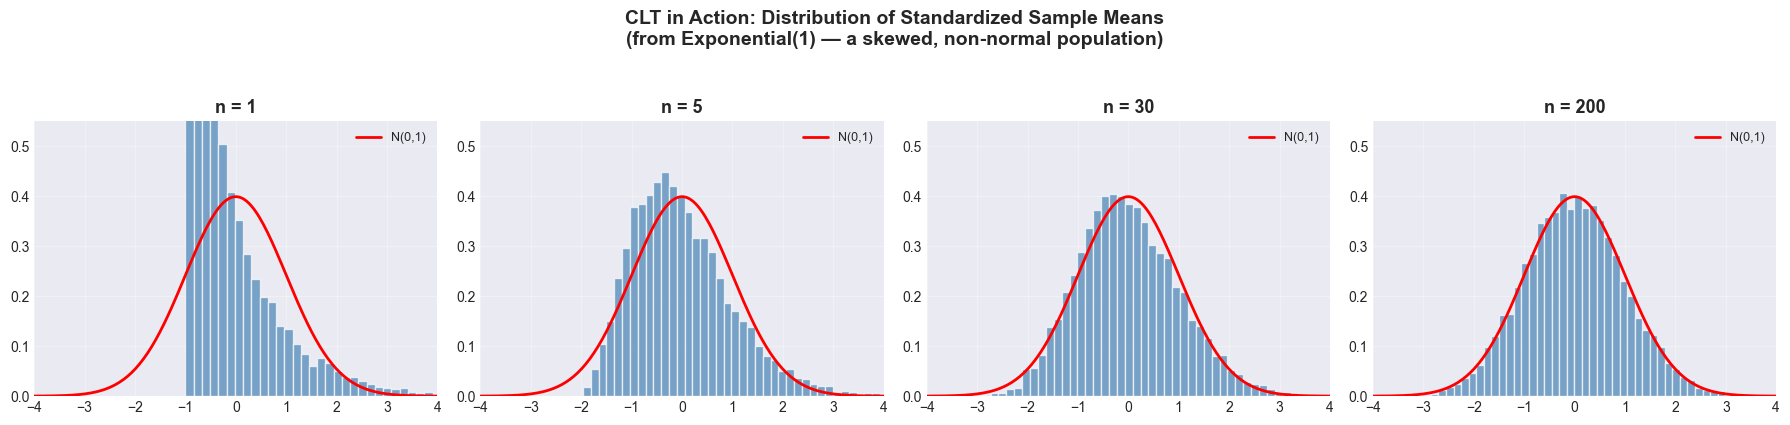


OBSERVATIONS:
• n = 1:   The sample mean IS the single draw → looks exponential (right-skewed)
• n = 5:   Already much more symmetric, but still visibly non-normal
• n = 30:  Nearly indistinguishable from the standard normal curve
• n = 200: Essentially perfect normal bell curve

KEY INSIGHT: The population is exponential (skewness = 2), yet the sample 
mean's distribution converges to N(0,1) as n grows. This is the CLT.



In [5]:
# ============================================================================
# CLT Demonstration: Sample means from an Exponential(1) distribution
# True mean μ = 1, true variance σ² = 1
# ============================================================================

np.random.seed(42)
num_simulations = 10_000
sample_sizes = [1, 5, 30, 200]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, n_sim in zip(axes, sample_sizes):
    # Draw all samples at once (vectorized — much faster than a Python loop)
    sample_means = np.random.exponential(scale=1.0, size=(num_simulations, n_sim)).mean(axis=1)
    
    # Standardize: z = (x̄ - μ) / (σ/√n)
    z_scores = (sample_means - 1.0) / (1.0 / np.sqrt(n_sim))
    
    ax.hist(z_scores, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    
    # Overlay standard normal
    t_grid = np.linspace(-4, 4, 200)
    ax.plot(t_grid, stats.norm.pdf(t_grid), 'r-', linewidth=2, label='N(0,1)')
    
    ax.set_title(f'n = {n_sim}', fontweight='bold', fontsize=13)
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 0.55)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle('CLT in Action: Distribution of Standardized Sample Means\n'
             '(from Exponential(1) — a skewed, non-normal population)',
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("""
OBSERVATIONS:
• n = 1:   The sample mean IS the single draw → looks exponential (right-skewed)
• n = 5:   Already much more symmetric, but still visibly non-normal
• n = 30:  Nearly indistinguishable from the standard normal curve
• n = 200: Essentially perfect normal bell curve

KEY INSIGHT: The population is exponential (skewness = 2), yet the sample 
mean's distribution converges to N(0,1) as n grows. This is the CLT.
""")

### 3.8 Why the Long-Run Variance Matters — A Quick Demonstration

The classical CLT says $\text{Var}(\bar{X}_n) = \sigma^2 / n$. But when data are autocorrelated, the true variance of the sample mean is $\sigma_{\text{LR}}^2 / n$, where $\sigma_{\text{LR}}^2 = \sum_{k=-\infty}^{\infty} \gamma_k$ can be much larger than $\sigma^2 = \gamma_0$.

The following simulation makes this concrete. We draw from an AR(1) process with autocorrelation $\rho = 0.5$ and compare the *actual* dispersion of sample means against what the naive formula $\sigma / \sqrt{n}$ predicts.

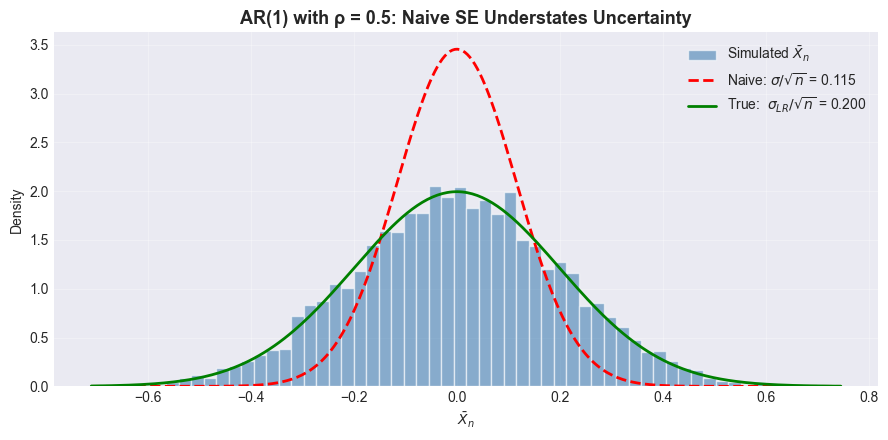

Naive SE (σ/√n):              0.1155
True SE  (σ_LR/√n):           0.2000
Empirical SD of sample means:  0.2031

The naive SE underestimates uncertainty by a factor of 1.73x.
This is exactly the problem that Newey-West standard errors fix (Section 7).


In [6]:
# ============================================================================
# Mixing CLT: naive SE vs true SE for autocorrelated data
# ============================================================================

np.random.seed(123)
n_ar = 100
rho_demo = 0.5
num_mc = 5000

# Generate num_mc independent AR(1) series, each of length n_ar
means_ar = np.zeros(num_mc)
for sim in range(num_mc):
    eps = np.random.randn(n_ar)
    ar_series = np.zeros(n_ar)
    ar_series[0] = eps[0]
    for t in range(1, n_ar):
        ar_series[t] = rho_demo * ar_series[t - 1] + eps[t]
    means_ar[sim] = ar_series.mean()

# Theoretical values
gamma0 = 1.0 / (1 - rho_demo**2)          # Var(X_t) for AR(1)
sigma_lr_sq = gamma0 * (1 + rho_demo) / (1 - rho_demo)  # long-run variance
naive_se = np.sqrt(gamma0 / n_ar)
true_se = np.sqrt(sigma_lr_sq / n_ar)

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.hist(means_ar, bins=60, density=True, alpha=0.6, color='steelblue',
        edgecolor='white', label='Simulated $\\bar{X}_n$')

grid = np.linspace(means_ar.min(), means_ar.max(), 300)
ax.plot(grid, stats.norm.pdf(grid, 0, naive_se), 'r--', linewidth=2,
        label=f'Naive: $\\sigma / \\sqrt{{n}}$ = {naive_se:.3f}')
ax.plot(grid, stats.norm.pdf(grid, 0, true_se), 'g-', linewidth=2,
        label=f'True:  $\\sigma_{{LR}} / \\sqrt{{n}}$ = {true_se:.3f}')

ax.set_title(f'AR(1) with ρ = {rho_demo}: Naive SE Understates Uncertainty',
             fontweight='bold', fontsize=13)
ax.set_xlabel('$\\bar{X}_n$')
ax.set_ylabel('Density')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Naive SE (σ/√n):              {naive_se:.4f}")
print(f"True SE  (σ_LR/√n):           {true_se:.4f}")
print(f"Empirical SD of sample means:  {means_ar.std():.4f}")
print(f"\nThe naive SE underestimates uncertainty by a factor of "
      f"{true_se / naive_se:.2f}x.")
print("This is exactly the problem that Newey-West standard errors fix (Section 7).")

---

## Section 4: Hypothesis Testing, t-Statistics, and p-Values — and the CLT Connection

### 4.1 The Framework

Hypothesis testing asks: "Could this result have arisen by chance?"

Suppose we observe a sample mean $\bar{x} = 1.0$ for a set of monthly excess returns. That sounds like a positive return — but with only 5 noisy observations, maybe the true mean is actually zero and we just got an unlucky draw. Hypothesis testing gives us a principled way to weigh the evidence.

We set up two competing hypotheses:

- $H_0$ (null hypothesis): The effect is zero. For example, $\mu = 0$ ("the true mean excess return is zero — the asset earns no premium").
- $H_1$ (alternative hypothesis): The effect is nonzero. For example, $\mu \neq 0$.

The logic proceeds by **proof by contradiction**: we temporarily *assume* $H_0$ is true and ask how surprising our observed data would be under that assumption. If the data would be very surprising (low probability), we reject $H_0$. If the data is not particularly unusual under $H_0$, we have no grounds to reject it.

This is analogous to a courtroom trial: the null hypothesis is "innocent until proven guilty." We need sufficient evidence (data) to reject this default presumption. Importantly, *failing* to reject $H_0$ does not prove $H_0$ is true — it merely means we lack enough evidence to overturn it.

### 4.2 The t-Distribution — What It Is and Where It Comes From

Before constructing our test statistic, we need to understand a distribution that plays a central role in small-sample inference: the **Student's $t$-distribution**.

**The problem.** If $X_1, \ldots, X_n$ are i.i.d. $\mathcal{N}(\mu, \sigma^2)$ and we *knew* the true $\sigma$, then

$$Z = \frac{\bar{X} - \mu}{\sigma / \sqrt{n}} \sim \mathcal{N}(0, 1) \quad \text{(exactly)}$$

But we almost never know $\sigma$. When we replace it with the sample standard deviation $s$, we introduce *extra randomness* in the denominator — $s$ itself varies from sample to sample. The resulting ratio is **no longer standard normal**.

**The solution (Student, 1908).** William Sealy Gosset (writing under the pseudonym "Student") showed that if the underlying data are normally distributed, then

$$T = \frac{\bar{X} - \mu}{s / \sqrt{n}} \sim t_{n-1}$$

follows a **$t$-distribution with $n - 1$ degrees of freedom**. The parameter $n - 1$ (degrees of freedom) matches the denominator in Bessel's correction, for the same reason: we used up one degree of freedom by estimating $\mu$ with $\bar{x}$.

**Key properties of the $t$-distribution:**

| Property | Description |
|----------|-------------|
| Shape | Bell-shaped and symmetric around zero, like the standard normal |
| Tails | **Heavier** than the normal — extreme values are more likely |
| Parameter | Single parameter: $\nu = n - 1$ degrees of freedom |
| Convergence | As $\nu \to \infty$, $t_\nu \to \mathcal{N}(0,1)$ |
| Variance | $\text{Var}(T) = \frac{\nu}{\nu - 2}$ for $\nu > 2$ (always $> 1$, so wider than $\mathcal{N}(0,1)$) |

The heavier tails reflect the **extra uncertainty** from estimating $\sigma$ with $s$. With small samples, $s$ can differ substantially from $\sigma$, so the $t$-distribution is noticeably wider than the normal. With large samples, $s \approx \sigma$ and the $t$-distribution is nearly indistinguishable from $\mathcal{N}(0,1)$.

For our data with $n = 5$, we have $\nu = 4$ degrees of freedom. The $t_4$ distribution has variance $4/(4-2) = 2$ — double that of the standard normal. This matters: using the normal instead of the $t$ would make us overconfident.

The plot below visualizes exactly this — notice how the $t_4$ distribution spreads more probability into the tails compared to $\mathcal{N}(0,1)$, and how larger $\nu$ brings the $t$-distribution closer to the normal.

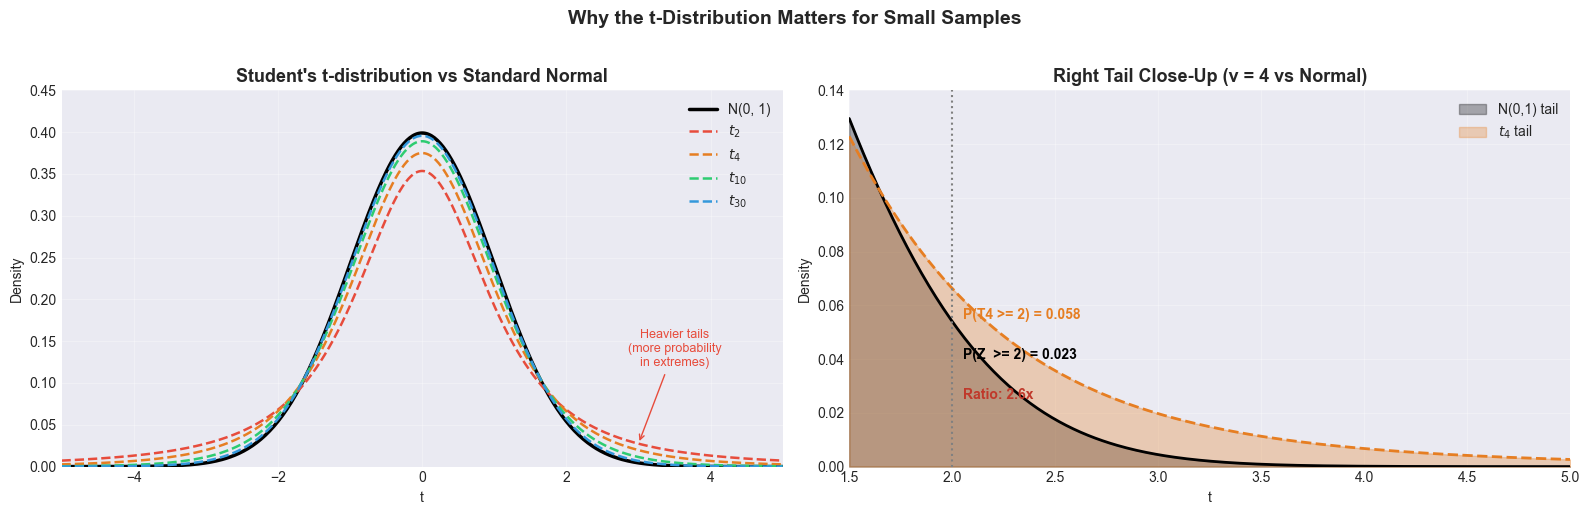


KEY OBSERVATIONS:
- The t-distribution is bell-shaped and symmetric like the normal, but with heavier tails.
- With v = 4 (our n = 5 example), the tails are substantially heavier -- the t4 allocates
  about 2.5x more probability beyond t = 2 than the standard normal.
- As v increases (v = 10, 30, ...), the t-distribution rapidly approaches N(0, 1).
- For v >= 30, the two are nearly indistinguishable in practice.
- This is why we MUST use the t-distribution for small samples: using the normal would
  make us overconfident (p-values too small, confidence intervals too narrow).



In [7]:
# ============================================================================
# Visualizing the t-distribution vs the standard normal
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Left panel: overlay several t-distributions against N(0,1) ---
t_grid = np.linspace(-5, 5, 500)
dfs = [2, 4, 10, 30]
colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db']

ax = axes[0]
ax.plot(t_grid, stats.norm.pdf(t_grid), 'k-', linewidth=2.5, label='N(0, 1)')
for df_val, color in zip(dfs, colors):
    ax.plot(t_grid, stats.t.pdf(t_grid, df=df_val), '--', linewidth=1.8,
            color=color, label=f'$t_{{{df_val}}}$')

ax.set_title('Student\'s t-distribution vs Standard Normal', fontweight='bold', fontsize=13)
ax.set_xlabel('t')
ax.set_ylabel('Density')
ax.legend(fontsize=10)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.45)
ax.grid(True, alpha=0.3)
ax.annotate('Heavier tails\n(more probability\nin extremes)',
            xy=(3.0, stats.t.pdf(3.0, df=2)), xytext=(3.5, 0.12),
            fontsize=9, ha='center',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'),
            color='#e74c3c')

# --- Right panel: zoom into the right tail to highlight the difference ---
ax2 = axes[1]
tail_grid = np.linspace(1.5, 5, 300)
ax2.fill_between(tail_grid, stats.norm.pdf(tail_grid), alpha=0.3, color='black', label='N(0,1) tail')
ax2.fill_between(tail_grid, stats.t.pdf(tail_grid, df=4), alpha=0.3, color='#e67e22', label='$t_4$ tail')
ax2.plot(tail_grid, stats.norm.pdf(tail_grid), 'k-', linewidth=2)
ax2.plot(tail_grid, stats.t.pdf(tail_grid, df=4), '--', linewidth=2, color='#e67e22')

# Mark the t = 2 line and show the p-value difference
ax2.axvline(x=2.0, color='gray', linestyle=':', linewidth=1.5)
p_norm_tail = 1 - stats.norm.cdf(2.0)
p_t4_tail = 1 - stats.t.cdf(2.0, df=4)
ax2.annotate(f'P(T4 >= 2) = {p_t4_tail:.3f}', xy=(2.05, 0.055), fontsize=10, color='#e67e22', fontweight='bold')
ax2.annotate(f'P(Z  >= 2) = {p_norm_tail:.3f}', xy=(2.05, 0.04), fontsize=10, color='black', fontweight='bold')
ax2.annotate(f'Ratio: {p_t4_tail/p_norm_tail:.1f}x', xy=(2.05, 0.025), fontsize=10, color='#c0392b', fontweight='bold')

ax2.set_title('Right Tail Close-Up (v = 4 vs Normal)', fontweight='bold', fontsize=13)
ax2.set_xlabel('t')
ax2.set_ylabel('Density')
ax2.legend(fontsize=10)
ax2.set_xlim(1.5, 5)
ax2.set_ylim(0, 0.14)
ax2.grid(True, alpha=0.3)

fig.suptitle('Why the t-Distribution Matters for Small Samples',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("""
KEY OBSERVATIONS:
- The t-distribution is bell-shaped and symmetric like the normal, but with heavier tails.
- With v = 4 (our n = 5 example), the tails are substantially heavier -- the t4 allocates
  about 2.5x more probability beyond t = 2 than the standard normal.
- As v increases (v = 10, 30, ...), the t-distribution rapidly approaches N(0, 1).
- For v >= 30, the two are nearly indistinguishable in practice.
- This is why we MUST use the t-distribution for small samples: using the normal would
  make us overconfident (p-values too small, confidence intervals too narrow).
""")

### 4.3 The t-Statistic

Under $H_0: \mu = 0$, the test statistic is:

$$t = \frac{\bar{x} - 0}{\widehat{\text{SE}}(\bar{x})} = \frac{\bar{x}}{s / \sqrt{n}}$$

This measures **how many standard errors the sample mean is away from zero**. The intuition is simple:

- If $\bar{x}$ is far from 0 (the null value) *relative to its own uncertainty*, that is strong evidence against $H_0$.
- If $\bar{x}$ is close to 0 relative to the noise, the data are consistent with $H_0$.

The $t$-statistic standardizes the sample mean into a "signal-to-noise ratio": the numerator is the signal ($\bar{x} - 0$) and the denominator is the noise ($s/\sqrt{n}$).

**Hand calculation** with our data:

$$t = \frac{1.0}{0.7071} = \frac{1.0}{\sqrt{0.5}} = \sqrt{2} \approx 1.4142$$

So our observed mean is about 1.41 standard errors above zero — present, but not overwhelmingly so.

### 4.4 The p-Value

The **p-value** is the probability of observing a test statistic at least as extreme as the one we got, **assuming $H_0$ is true**. "At least as extreme" means at least as far from zero in either direction (for a two-sided test).

Formally, for a two-sided test with $n - 1 = 4$ degrees of freedom:

$$p = P\bigl(|T_4| \geq |t_{\text{obs}}|\bigr) = 2 \times P(T_4 \geq 1.4142)$$

where $T_4$ denotes a random variable following a $t$-distribution with 4 degrees of freedom.

**How to interpret the p-value:**

- A **small** p-value (e.g., $p < 0.05$) means: "Data this extreme would be very unlikely if $H_0$ were true." This is evidence against $H_0$.
- A **large** p-value means: "Data this extreme is not unusual under $H_0$." We have no strong reason to reject $H_0$.
- The p-value is **not** the probability that $H_0$ is true. It is the probability of seeing data this extreme *given* that $H_0$ is true — a crucial distinction.

The conventional significance level is $\alpha = 0.05$, meaning we reject $H_0$ if $p < 0.05$. This corresponds to a $|t|$ threshold of about 2 (more precisely, $t_{0.025, \nu}$ for the relevant degrees of freedom). The "rule of thumb" you often hear — "a $t$-statistic above 2 is significant" — comes from this.

### 4.5 Why a t-Distribution Instead of the Standard Normal?

When the sample size $n$ is small and we estimate $\sigma$ with $s$, the ratio $\bar{x} / (s/\sqrt{n})$ does **not** exactly follow $\mathcal{N}(0,1)$. As derived in Section 4.2, it follows a **$t$-distribution** with $n - 1$ degrees of freedom.

Using the standard normal when you should use the $t$-distribution would **understate the p-value** — you'd think data is more significant than it actually is. This is because the $t$-distribution allocates more probability to the tails.

For example, $P(|Z| \geq 2) = 0.046$ under the standard normal, but $P(|T_4| \geq 2) = 0.116$ under $t_4$. That is a factor of 2.5 difference. With 4 degrees of freedom, the normal would mislead you substantially.

As $n \to \infty$, the $t_{n-1}$ distribution converges to $\mathcal{N}(0,1)$. For $n \geq 30$, the difference is already small. This convergence is related to the CLT: with enough data, estimating $\sigma$ with $s$ introduces negligible additional uncertainty, and the extra randomness in the denominator vanishes.

### 4.6 Confidence Intervals

A **confidence interval** inverts the hypothesis test. Instead of asking "Is $\mu = 0$?", it asks: "What range of $\mu$ values are consistent with our data?"

A 95% confidence interval for $\mu$ is:

$$\bar{x} \pm t_{0.025,\, n-1} \times \frac{s}{\sqrt{n}}$$

where $t_{0.025,\, 4} \approx 2.776$ is the 97.5th percentile of the $t_4$ distribution. We use the $t$-distribution (not the normal) for the same reason as above: we are estimating $\sigma$ from a small sample.

The critical value $2.776$ is notably larger than the $1.96$ we would use from the standard normal. This makes the confidence interval wider, appropriately reflecting our greater uncertainty with $n = 5$.

**Hand calculation:**

$$\text{CI} = 1.0 \pm 2.776 \times 0.7071 = 1.0 \pm 1.963 = [-0.963, \; 2.963]$$

Since this interval **contains zero**, we cannot reject $H_0: \mu = 0$ at the 5% level — consistent with our p-value being above 0.05.

**Interpretation.** "If we repeated this experiment many times and computed a 95% CI each time, about 95% of those intervals would contain the true $\mu$." It does *not* mean there is a 95% probability that $\mu$ lies in this particular interval — $\mu$ is a fixed (unknown) number, not a random variable.

In [8]:
# ============================================================================
# Hand-checkable hypothesis test
# Uses: mean, se_mean, n from Sections 1–2 (cells above)
# ============================================================================

t_stat = mean / se_mean
df_t = n - 1
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df_t))
t_crit = stats.t.ppf(0.975, df=df_t)
ci_low = mean - t_crit * se_mean
ci_high = mean + t_crit * se_mean

print("HYPOTHESIS TEST: H₀: μ = 0  vs  H₁: μ ≠ 0")
print("=" * 55)
print(f"  x̄ = {mean}")
print(f"  SE(x̄) = {se_mean:.4f}")
print(f"  t = x̄ / SE = {mean} / {se_mean:.4f} = {t_stat:.4f}")
print(f"  Degrees of freedom = n - 1 = {df_t}")
print(f"\n  p-value (two-sided) = {p_value:.4f}")
print(f"  t-critical (α=0.05, df={df_t}) = ±{t_crit:.3f}")
print(f"  95% CI = [{ci_low:.3f}, {ci_high:.3f}]")
print(f"\n  Decision: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'} at 5% level")
print(f"  (CI {'does NOT contain' if ci_low > 0 or ci_high < 0 else 'contains'} zero — consistent with p-value)")

HYPOTHESIS TEST: H₀: μ = 0  vs  H₁: μ ≠ 0
  x̄ = 1.0
  SE(x̄) = 0.7071
  t = x̄ / SE = 1.0 / 0.7071 = 1.4142
  Degrees of freedom = n - 1 = 4

  p-value (two-sided) = 0.2302
  t-critical (α=0.05, df=4) = ±2.776
  95% CI = [-0.963, 2.963]

  Decision: Fail to reject H₀ at 5% level
  (CI contains zero — consistent with p-value)


### 4.7 Why the CLT Justifies Normal p-Values

Let us pause and appreciate the deep connection between the CLT and hypothesis testing. It is the intellectual heart of this entire notebook and fundamental to understanding how Newey-West works.

Above we used the **t-distribution** to compute the p-value. This was exact — it required that the $X_i$ are normally distributed (or that we use an exact finite-sample result). But in practice, financial returns are **not** normally distributed: they have fat tails, skewness, and time-varying volatility.

**So why do our p-values still work?**

The answer is the CLT. Here is the argument, spelled out carefully:

### 4.8 The Argument in Five Steps

**Step 1.** We want to test $H_0: \mu = 0$. Our test statistic is:

$$t = \frac{\bar{X}_n}{s / \sqrt{n}}$$

**Step 2.** By the CLT, for large $n$:

$$\frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0,1)$$

Under $H_0$ ($\mu = 0$): $\frac{\bar{X}_n}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0,1)$.

**Step 3.** By the Law of Large Numbers, $s^2 \xrightarrow{p} \sigma^2$, i.e. the sample variance converges in probability to the true variance.

**Step 4.** By **Slutsky's theorem**, replacing $\sigma$ with $s$ in the denominator does not change the limiting distribution.

> **Slutsky's Theorem.** If $X_n \xrightarrow{d} X$ and $Y_n \xrightarrow{p} c$ (a constant), then $X_n / Y_n \xrightarrow{d} X / c$, and more generally $g(X_n, Y_n) \xrightarrow{d} g(X, c)$ for any continuous $g$.

Applying this with $X_n = \bar{X}_n / (\sigma/\sqrt{n}) \xrightarrow{d} \mathcal{N}(0,1)$ and $Y_n = s/\sigma \xrightarrow{p} 1$:

$$t = \frac{\bar{X}_n}{s / \sqrt{n}} = \frac{\bar{X}_n / (\sigma/\sqrt{n})}{s / \sigma} \xrightarrow{d} \frac{\mathcal{N}(0,1)}{1} = \mathcal{N}(0,1)$$

**Step 5.** Therefore, for large $n$, we can compute p-values using the standard normal $\mathcal{N}(0,1)$ table (or the $t_{n-1}$ distribution, which is nearly identical for large $n$).

### 4.9 What "Nonparametric" Means Here

Notice what we **did not** assume in Steps 1–5:

- We did **not** assume the $X_i$ are normally distributed.
- We did **not** assume the $X_i$ have any particular distributional shape.
- We **only** assumed they have a finite mean and variance and are (approximately) independent.

This is what makes the CLT-based inference **nonparametric** (more precisely, **semiparametric** or **distribution-free**): it works regardless of the population distribution, provided $n$ is large enough.

### 4.10 How Large is "Large Enough"?

The speed of CLT convergence depends on the distribution's skewness and kurtosis:

| Distribution | Skewness | Kurtosis | $n$ needed for good approximation |
|-------------|----------|----------|-----------------------------------|
| Normal      | 0        | 3        | Any $n$ (exact)                   |
| Uniform     | 0        | 1.8      | $n \geq 10$                       |
| Exponential | 2        | 9        | $n \geq 30$                       |
| Highly skewed (e.g., Pareto) | Large | Very large | $n \geq 100+$ |
| Financial returns (mild fat tails) | ~0 | 4–6 | $n \geq 30–50$ |

For monthly Fama-French data with 100–200 observations, the CLT approximation is excellent. **This is why finance researchers can use standard-normal-based p-values with Newey-West standard errors even though returns are not normally distributed.**

### 4.11 A Subtle but Critical Point

The CLT tells us that $\bar{X}_n$ is approximately normal. This does **not** mean:

- ❌ Individual observations $X_i$ are normal
- ❌ Residuals from a regression are normal  
- ❌ The error term $\epsilon$ is normal

It **does** mean:

- ✅ This works even when the underlying data is decidedly non-normal
- ✅ Functions of averages (like regression coefficients $\hat{\beta}$, which are weighted averages of the data) are approximately normal for large $n$
- ✅ We can use the normal distribution to compute p-values for these statistics

In [9]:
# ============================================================================
# Demonstration: CLT-based p-value vs exact t-distribution p-value
# As n grows, they converge — showing the CLT justification in action
# ============================================================================

print("COMPARISON: t-distribution vs standard normal p-values")
print("=" * 65)
print(f"{'n':>6}  {'t-stat':>8}  {'p (t-dist)':>12}  {'p (normal)':>12}  {'Δp':>10}")
print("-" * 65)

# For each sample size, compute p-value under both distributions
for n_demo in [5, 10, 30, 50, 100, 200, 500]:
    t_val = 2.0  # Fix t-statistic at 2.0 for comparison
    p_t = 2 * (1 - stats.t.cdf(t_val, df=n_demo - 1))
    p_z = 2 * (1 - stats.norm.cdf(t_val))
    print(f"{n_demo:6d}  {t_val:8.2f}  {p_t:12.6f}  {p_z:12.6f}  {abs(p_t - p_z):10.6f}")

print(f"\nAs n → ∞, the t-distribution p-values converge to the normal p-values.")
print(f"For n ≥ 100 (typical in Fama-French analysis), the difference is < 0.002.")
print(f"\nThis is why Newey-West uses the standard normal: with n ≈ 100-200 months,")
print(f"the CLT guarantees the t-statistic is approximately N(0,1).")

COMPARISON: t-distribution vs standard normal p-values
     n    t-stat    p (t-dist)    p (normal)          Δp
-----------------------------------------------------------------
     5      2.00      0.116117      0.045500    0.070616
    10      2.00      0.076553      0.045500    0.031053
    30      2.00      0.054944      0.045500    0.009443
    50      2.00      0.051059      0.045500    0.005559
   100      2.00      0.048240      0.045500    0.002739
   200      2.00      0.046860      0.045500    0.001360
   500      2.00      0.046042      0.045500    0.000542

As n → ∞, the t-distribution p-values converge to the normal p-values.
For n ≥ 100 (typical in Fama-French analysis), the difference is < 0.002.

This is why Newey-West uses the standard normal: with n ≈ 100-200 months,
the CLT guarantees the t-statistic is approximately N(0,1).


---

## Section 5: Linear Regression and OLS

We now shift from testing a single mean to analyzing the **relationship between variables**. This is the core of empirical finance: the Fama-French model asks whether exposure to market, size, and value *factors* explains the cross-section of expected returns — a question that is fundamentally about regression.

### 5.1 What Is Regression?

Regression answers the question: **how does one variable change, on average, when another variable changes?**

Concretely, given paired observations $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, we model:

$$y_i = \alpha + \beta x_i + \epsilon_i$$

where:
- $\alpha$ (the **intercept**) is the expected value of $y$ when $x = 0$,
- $\beta$ (the **slope**) is the expected change in $y$ per one-unit change in $x$,
- $\epsilon_i$ (the **error** or **residual**) captures everything about $y_i$ that is not explained by $x_i$.

In the Fama-French context, $y_i$ is the excess return of a portfolio, $x_i$ is the excess return of the market (or a factor), and $\beta$ measures the portfolio's *sensitivity* (or *loading*) on that factor. A positive $\beta$ on the market factor means the portfolio tends to go up when the market goes up, and vice versa. The intercept $\alpha$ — often called **Jensen's alpha** — measures the average return that is *not* explained by factor exposure. If $\alpha > 0$, the portfolio earns a premium beyond what its risk exposure would predict.

### 5.2 The Idea: Minimizing Squared Errors

How do we choose $\alpha$ and $\beta$? The **Ordinary Least Squares (OLS)** principle says: choose the line that makes the residuals $\hat{\epsilon}_i = y_i - (\hat{\alpha} + \hat{\beta} x_i)$ as small as possible, in the sense of minimizing the **sum of squared residuals**:

$$\text{RSS} = \sum_{i=1}^n \hat{\epsilon}_i^2 = \sum_{i=1}^n \bigl(y_i - \hat{\alpha} - \hat{\beta} x_i\bigr)^2$$

Why squared errors rather than absolute errors? Three reasons:
1. **Differentiability** — Squared errors are smooth, so we can use calculus to find the minimum.
2. **Unique solution** — The squared-error problem always has exactly one solution (for non-degenerate data).
3. **Connection to the CLT** — Under standard assumptions, the OLS estimator is the best linear unbiased estimator (BLUE), and its sampling distribution is governed by the CLT.

### 5.3 Deriving the OLS Formulas (Scalar Case)

To minimize $\text{RSS}$, we take partial derivatives with respect to $\alpha$ and $\beta$ and set them to zero.

**Derivative with respect to $\alpha$:**

$$\frac{\partial \, \text{RSS}}{\partial \alpha} = -2\sum_{i=1}^n (y_i - \alpha - \beta x_i) = 0$$

This yields the **first normal equation**:

$$\sum_{i=1}^n y_i = n\alpha + \beta \sum_{i=1}^n x_i \qquad \Longrightarrow \qquad \hat{\alpha} = \bar{y} - \hat{\beta}\bar{x}$$

**Derivative with respect to $\beta$:**

$$\frac{\partial \, \text{RSS}}{\partial \beta} = -2\sum_{i=1}^n x_i(y_i - \alpha - \beta x_i) = 0$$

Substituting $\hat{\alpha} = \bar{y} - \hat{\beta}\bar{x}$ and simplifying gives the **second normal equation**:

$$\hat{\beta} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} = \frac{\text{Cov}(x, y)}{\text{Var}(x)}$$

This is an elegant result: **the slope equals the sample covariance of $x$ and $y$ divided by the sample variance of $x$**. This makes intuitive sense — $\hat{\beta}$ measures how much $y$ moves *per unit of $x$-variability*.

### 5.4 A Geometric Intuition

Think of the $n$ observed $y$-values as a point in $n$-dimensional space. The set of all vectors of the form $\hat{\alpha}\mathbf{1} + \hat{\beta}\mathbf{x}$ (where $\mathbf{1}$ is the column of ones) traces out a 2-dimensional *plane* within that $n$-dimensional space.

OLS finds the point on that plane that is **closest** to $\mathbf{y}$ — that is, the **orthogonal projection** of $\mathbf{y}$ onto the column space of $\mathbf{X}$. The residual vector $\hat{\boldsymbol{\epsilon}} = \mathbf{y} - \hat{\mathbf{y}}$ is perpendicular to the column space, which is precisely the condition $\mathbf{X}^T\hat{\boldsymbol{\epsilon}} = \mathbf{0}$ — the normal equations in matrix form.

This geometric picture explains several properties of OLS that can otherwise seem mysterious:
- The **residuals sum to zero** (because $\hat{\boldsymbol{\epsilon}}$ is perpendicular to the constant column $\mathbf{1}$).
- The **fitted values and residuals are uncorrelated** (because $\hat{\mathbf{y}}$ lies in the column space while $\hat{\boldsymbol{\epsilon}}$ is perpendicular to it).
- $R^2$ measures the **cosine squared** of the angle between $\mathbf{y}$ and $\hat{\mathbf{y}}$.

### 5.5 Hand Calculation with Our Data

Using the dataset from Section 1: $x = [2, -1, 3, 0, 1]$ and $y = [3, -2, 4, 1, 0]$.

From Section 1 we already computed: $\bar{x} = 1.0$, $\bar{y} = 1.2$.

**Step 1: Compute the deviations.**

| $i$ | $x_i$ | $y_i$ | $x_i - \bar{x}$ | $y_i - \bar{y}$ | $(x_i - \bar{x})(y_i - \bar{y})$ | $(x_i - \bar{x})^2$ |
|-----|--------|--------|-----------------|-----------------|----------------------------------|---------------------|
| 1   | 2      | 3      | 1.0             | 1.8             | 1.80                             | 1.00                |
| 2   | −1     | −2     | −2.0            | −3.2            | 6.40                             | 4.00                |
| 3   | 3      | 4      | 2.0             | 2.8             | 5.60                             | 4.00                |
| 4   | 0      | 1      | −1.0            | −0.2            | 0.20                             | 1.00                |
| 5   | 1      | 0      | 0.0             | −1.2            | 0.00                             | 0.00                |
|     |        |        |                 |                 | **Sum = 14.0**                   | **Sum = 10.0**      |

**Step 2: Compute $\hat{\beta}$ and $\hat{\alpha}$.**

$$\hat{\beta} = \frac{14.0}{10.0} = 1.4$$

$$\hat{\alpha} = \bar{y} - \hat{\beta}\bar{x} = 1.2 - 1.4(1.0) = -0.2$$

So the fitted line is $\hat{y} = -0.2 + 1.4x$.

**Interpretation:** Each additional unit of $x$ is associated with a 1.4-unit increase in $y$. The intercept $-0.2$ is the predicted value of $y$ when $x = 0$.

### 5.6 Visualizing the Fit

The code below plots the data and the fitted regression line, and marks the residuals as vertical distances from each point to the line — making concrete the idea that OLS minimizes the sum of these squared vertical distances.

SCALAR OLS — HAND VERIFICATION
  x̄ = 1.0,  ȳ = 1.2
  Σ(xᵢ - x̄)(yᵢ - ȳ) = 14.0
  Σ(xᵢ - x̄)²         = 10.0

  β̂ = 14.0/10.0 = 1.4
  α̂ = 1.2 − 1.4×1.0 = -0.19999999999999996

  Fitted values ŷ: [ 2.6 -1.6  4.  -0.2  1.2]
  Residuals ε̂:     [ 4.0000000e-01 -4.0000000e-01  8.8817842e-16  1.2000000e+00
 -1.2000000e+00]
  Σε̂ᵢ = 0.0000000000  (should ≈ 0)
  RSS = Σε̂ᵢ² = 3.20

  SS_tot = 22.80
  R² = 1 − RSS/SS_tot = 1 − 3.20/22.80 = 0.8596
  → 86.0% of the variation in y is explained by x.


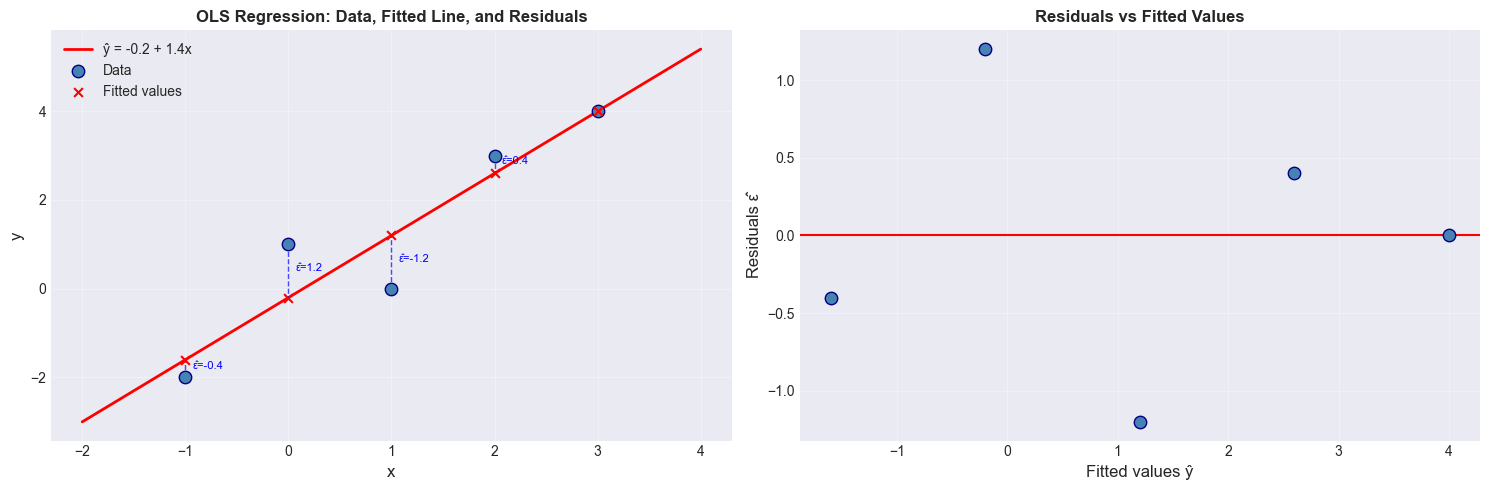


KEY OBSERVATIONS:
• The fitted line passes through (x̄, ȳ) = (1.0, 1.2) — always true for OLS with an intercept.
• Residuals sum to zero — a consequence of including an intercept.
• The residual plot (right) shows no obvious pattern — consistent with a 
  reasonable linear fit (though with only 5 points, diagnostics are limited).
• R² = 86.0%: most of the variation in y is captured by the linear relationship.



In [10]:
# ============================================================================
# Section 5: Linear Regression and OLS — Hand calculation & visualization
# ============================================================================

# Regression data — same x, y from Section 1, renamed to avoid shadowing
# the single-variable analysis (mean, std, se_mean used in Section 4).
x_reg = np.array([2, -1, 3, 0, 1], dtype=float)
y_reg = np.array([3, -2, 4, 1, 0], dtype=float)
n_reg = len(x_reg)

# --- Step 1: Compute β̂ and α̂ using the scalar formulas ---
x_bar = x_reg.mean()
y_bar = y_reg.mean()

numerator = np.sum((x_reg - x_bar) * (y_reg - y_bar))   # Cov(x,y) * (n-1)
denominator = np.sum((x_reg - x_bar) ** 2)                # Var(x) * (n-1)

beta_hat = numerator / denominator
alpha_hat = y_bar - beta_hat * x_bar

print("SCALAR OLS — HAND VERIFICATION")
print("=" * 55)
print(f"  x̄ = {x_bar},  ȳ = {y_bar}")
print(f"  Σ(xᵢ - x̄)(yᵢ - ȳ) = {numerator}")
print(f"  Σ(xᵢ - x̄)²         = {denominator}")
print(f"\n  β̂ = {numerator}/{denominator} = {beta_hat}")
print(f"  α̂ = {y_bar} − {beta_hat}×{x_bar} = {alpha_hat}")

# --- Step 2: Fitted values and residuals ---
y_hat = alpha_hat + beta_hat * x_reg
residuals = y_reg - y_hat
RSS = np.sum(residuals ** 2)

print(f"\n  Fitted values ŷ: {y_hat}")
print(f"  Residuals ε̂:     {residuals}")
print(f"  Σε̂ᵢ = {residuals.sum():.10f}  (should ≈ 0)")
print(f"  RSS = Σε̂ᵢ² = {RSS:.2f}")

# --- Step 3: R² ---
SS_tot = np.sum((y_reg - y_bar) ** 2)
R_squared = 1 - RSS / SS_tot
print(f"\n  SS_tot = {SS_tot:.2f}")
print(f"  R² = 1 − RSS/SS_tot = 1 − {RSS:.2f}/{SS_tot:.2f} = {R_squared:.4f}")
print(f"  → {R_squared*100:.1f}% of the variation in y is explained by x.")

# ============================================================================
# Visualization: data, fitted line, and residuals
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Left panel: scatter + fitted line + residuals ---
ax = axes[0]
x_grid = np.linspace(-2, 4, 100)
y_grid = alpha_hat + beta_hat * x_grid

ax.plot(x_grid, y_grid, 'r-', linewidth=2, label=f'ŷ = {alpha_hat:.1f} + {beta_hat:.1f}x')

# Draw residuals as vertical lines
for xi, yi, yhi in zip(x_reg, y_reg, y_hat):
    ax.plot([xi, xi], [yi, yhi], 'b--', linewidth=1, alpha=0.7)

ax.scatter(x_reg, y_reg, s=80, c='steelblue', edgecolors='navy', zorder=5, label='Data')
ax.scatter(x_reg, y_hat, s=40, c='red', marker='x', zorder=5, label='Fitted values')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('OLS Regression: Data, Fitted Line, and Residuals', fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Annotate residuals
for i, (xi, yi, ei) in enumerate(zip(x_reg, y_reg, residuals)):
    if abs(ei) > 0.05:
        ax.annotate(f'ε̂={ei:.1f}', xy=(xi, (yi + y_hat[i])/2),
                    fontsize=8, color='blue', ha='left',
                    xytext=(5, 0), textcoords='offset points')

# --- Right panel: residuals vs fitted values ---
ax2 = axes[1]
ax2.scatter(y_hat, residuals, s=80, c='steelblue', edgecolors='navy', zorder=5)
ax2.axhline(y=0, color='red', linestyle='-', linewidth=1.5)
ax2.set_xlabel('Fitted values ŷ', fontsize=12)
ax2.set_ylabel('Residuals ε̂', fontsize=12)
ax2.set_title('Residuals vs Fitted Values', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
KEY OBSERVATIONS:
• The fitted line passes through (x̄, ȳ) = (1.0, 1.2) — always true for OLS with an intercept.
• Residuals sum to zero — a consequence of including an intercept.
• The residual plot (right) shows no obvious pattern — consistent with a 
  reasonable linear fit (though with only 5 points, diagnostics are limited).
• R² = {:.1f}%: most of the variation in y is captured by the linear relationship.
""".format(R_squared * 100))

### 5.7 The Matrix Formulation

The scalar formulas from Section 5.3 work for simple regression (one regressor). But the Fama-French model has *three* regressors (market, size, value) — and in general we need to handle $k$ regressors simultaneously. Matrix algebra provides a compact, general framework that works for any number of regressors. It also sets up the variance formulas we will need for robust standard errors in subsequent sections.

**The model in matrix form.** Stack all $n$ observations into a single equation:

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$$

where:
- $\mathbf{y}$ is the $n \times 1$ vector of outcomes,
- $\mathbf{X}$ is the $n \times k$ **design matrix** — its first column is a column of ones (the intercept), and the remaining columns are the regressors,
- $\boldsymbol{\beta}$ is the $k \times 1$ vector of parameters $(\alpha, \beta_1, \ldots, \beta_{k-1})^T$,
- $\boldsymbol{\epsilon}$ is the $n \times 1$ vector of errors.

For our 5-observation simple regression, $k = 2$ (intercept + one slope):

$$\mathbf{X} = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{pmatrix}, \qquad \boldsymbol{\beta} = \begin{pmatrix} \alpha \\ \beta \end{pmatrix}$$

**Deriving the OLS estimator.** The residual sum of squares in matrix form is:

$$\text{RSS}(\boldsymbol{\beta}) = (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})$$

Expanding:

$$\text{RSS}(\boldsymbol{\beta}) = \mathbf{y}^T\mathbf{y} - 2\boldsymbol{\beta}^T\mathbf{X}^T\mathbf{y} + \boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta}$$

To minimize, we take the **matrix derivative** (gradient) and set it to zero. The key matrix calculus identities are:
- $\frac{\partial}{\partial \boldsymbol{\beta}}(\boldsymbol{\beta}^T\mathbf{a}) = \mathbf{a}$, for any constant vector $\mathbf{a}$;
- $\frac{\partial}{\partial \boldsymbol{\beta}}(\boldsymbol{\beta}^T\mathbf{A}\boldsymbol{\beta}) = 2\mathbf{A}\boldsymbol{\beta}$, for any symmetric matrix $\mathbf{A}$.

Applying these:

$$\frac{\partial \, \text{RSS}}{\partial \boldsymbol{\beta}} = -2\mathbf{X}^T\mathbf{y} + 2\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{0}$$

Rearranging gives the **normal equations**:

$$\boxed{\mathbf{X}^T\mathbf{X}\hat{\boldsymbol{\beta}} = \mathbf{X}^T\mathbf{y}}$$

This is a system of $k$ linear equations in $k$ unknowns. If $\mathbf{X}^T\mathbf{X}$ is invertible (which requires that no regressor is a perfect linear combination of the others), we can solve directly:

$$\boxed{\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}}$$

---

**Interpreting the components.** Each piece of this formula has a clear meaning:

| Expression | Dimension | Meaning |
|:---|:---:|:---|
| $\mathbf{X}^T\mathbf{X}$ | $k \times k$ | **Information matrix** — measures the total "variation" in the regressors. Larger values (more spread in $x$) mean more precise estimates. |
| $\mathbf{X}^T\mathbf{y}$ | $k \times 1$ | **Cross-moment vector** — measures how each regressor covaries with the outcome. |
| $(\mathbf{X}^T\mathbf{X})^{-1}$ | $k \times k$ | Inverts the information matrix, converting raw covariation into properly scaled regression coefficients. |

The formula says: *$\hat{\boldsymbol{\beta}}$ equals the covariation of regressors with outcomes, scaled by the inverse of the regressors' own variation*. This is the multivariate generalization of $\hat{\beta} = \text{Cov}(x,y) / \text{Var}(x)$.

---

**Connection to projection (Section 5.4 revisited).** The normal equations can be rewritten as:

$$\mathbf{X}^T(\mathbf{y} - \mathbf{X}\hat{\boldsymbol{\beta}}) = \mathbf{0} \qquad \Longleftrightarrow \qquad \mathbf{X}^T\hat{\boldsymbol{\epsilon}} = \mathbf{0}$$

This says the **residual vector is orthogonal to every column of $\mathbf{X}$** — exactly the geometric projection condition from Section 5.4. The fitted values are the orthogonal projection of $\mathbf{y}$ onto the column space of $\mathbf{X}$:

$$\hat{\mathbf{y}} = \mathbf{X}\hat{\boldsymbol{\beta}} = \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} = \mathbf{H}\mathbf{y}$$

where $\mathbf{H} = \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T$ is the **hat matrix** (or projection matrix). It "puts the hat on $\mathbf{y}$." The hat matrix is symmetric ($\mathbf{H}^T = \mathbf{H}$) and idempotent ($\mathbf{H}^2 = \mathbf{H}$) — properties that projections always have.

---

---

### 5.8 From Coefficients to Standard Errors: Deriving $\text{Var}(\hat{\boldsymbol{\beta}})$

Computing $\hat{\boldsymbol{\beta}}$ is only half the job. To do inference (test hypotheses, build confidence intervals), we need to know **how uncertain** our estimates are. This requires deriving the variance of the estimator.

**Step 1 — Express $\hat{\boldsymbol{\beta}}$ in terms of the true errors.** Substituting $\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$ into the OLS formula:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T(\mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}) = \boldsymbol{\beta} + (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\epsilon}$$

This is a fundamental decomposition: $\hat{\boldsymbol{\beta}}$ equals the truth $\boldsymbol{\beta}$ plus a **noise term** $(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\epsilon}$ that depends on the errors. Two immediate consequences:

1. **Unbiasedness:** If $E[\boldsymbol{\epsilon} \mid \mathbf{X}] = \mathbf{0}$, then $E[\hat{\boldsymbol{\beta}} \mid \mathbf{X}] = \boldsymbol{\beta}$.
2. **Consistency:** As $n \to \infty$, the noise term vanishes (under regularity conditions), so $\hat{\boldsymbol{\beta}} \xrightarrow{p} \boldsymbol{\beta}$.

**Step 2 — The variance-covariance matrix: what it is and why we need it.** For a *scalar* random variable $Z$, its variance is $\text{Var}(Z) = E[(Z - E[Z])^2]$ — a single number. But $\hat{\boldsymbol{\beta}}$ is a *vector* of $k$ random variables $(\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{k-1})^T$. We need a *matrix* that captures the variance of each component **and** the covariances between components. This is the **variance-covariance matrix**, defined as:

$$\text{Var}(\hat{\boldsymbol{\beta}}) \;\equiv\; E\bigl[(\hat{\boldsymbol{\beta}} - E[\hat{\boldsymbol{\beta}}])(\hat{\boldsymbol{\beta}} - E[\hat{\boldsymbol{\beta}}])^T\bigr]$$

This is a $k \times k$ matrix. Its structure is:

$$\text{Var}(\hat{\boldsymbol{\beta}}) = \begin{pmatrix} \text{Var}(\hat{\beta}_0) & \text{Cov}(\hat{\beta}_0, \hat{\beta}_1) & \cdots & \text{Cov}(\hat{\beta}_0, \hat{\beta}_{k-1}) \\ \text{Cov}(\hat{\beta}_1, \hat{\beta}_0) & \text{Var}(\hat{\beta}_1) & \cdots & \text{Cov}(\hat{\beta}_1, \hat{\beta}_{k-1}) \\ \vdots & \vdots & \ddots & \vdots \\ \text{Cov}(\hat{\beta}_{k-1}, \hat{\beta}_0) & \text{Cov}(\hat{\beta}_{k-1}, \hat{\beta}_1) & \cdots & \text{Var}(\hat{\beta}_{k-1}) \end{pmatrix}$$

- The **diagonal entries** $[\text{Var}(\hat{\boldsymbol{\beta}})]_{jj} = \text{Var}(\hat{\beta}_j)$ are the variances — the standard errors come directly from these: $\text{SE}(\hat{\beta}_j) = \sqrt{\text{Var}(\hat{\beta}_j)}$.
- The **off-diagonal entries** are covariances between different coefficient estimates — these matter when testing *joint* hypotheses (e.g., are multiple coefficients simultaneously zero?).

**"Conditional on $\mathbf{X}$"** means we treat the regressor matrix as fixed (non-random) and ask: over repeated samples of $\boldsymbol{\epsilon}$ drawn from the same error distribution, how much would $\hat{\boldsymbol{\beta}}$ vary? This is the standard frequentist perspective — the randomness comes only from $\boldsymbol{\epsilon}$, not from $\mathbf{X}$.

**Step 3 — Derive the formula.** From Step 1, we know $\hat{\boldsymbol{\beta}} - \boldsymbol{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\epsilon}$. Since $E[\hat{\boldsymbol{\beta}}] = \boldsymbol{\beta}$ (unbiasedness), we can substitute directly into the definition:

$$\text{Var}(\hat{\boldsymbol{\beta}}) = E\bigl[(\hat{\boldsymbol{\beta}} - \boldsymbol{\beta})(\hat{\boldsymbol{\beta}} - \boldsymbol{\beta})^T\bigr]$$

$$= E\Bigl[\bigl((\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\epsilon}\bigr)\bigl((\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\epsilon}\bigr)^T\Bigr]$$

Using the transpose rule $(\mathbf{A}\mathbf{b})^T = \mathbf{b}^T\mathbf{A}^T$:

$$= E\Bigl[(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\;\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T\;\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\Bigr]$$

Since $\mathbf{X}$ is treated as fixed, only $\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T$ is random, so the expectation passes through:

$$= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \; \underbrace{E[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T]}_{\boldsymbol{\Omega}} \; \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}$$

Here $\boldsymbol{\Omega} = E[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T]$ is the $n \times n$ variance-covariance matrix *of the errors* — its $(i,j)$ entry is $E[\epsilon_i \epsilon_j]$. The diagonal entries are the individual error variances $E[\epsilon_i^2]$, and the off-diagonals capture any correlation between errors at different observations.

This gives us the **sandwich formula** — so named for its bread-meat-bread structure:

$$\boxed{\text{Var}(\hat{\boldsymbol{\beta}}) = \underbrace{(\mathbf{X}^T\mathbf{X})^{-1}}_{\text{bread}} \underbrace{\mathbf{X}^T\boldsymbol{\Omega}\mathbf{X}}_{\text{meat}} \underbrace{(\mathbf{X}^T\mathbf{X})^{-1}}_{\text{bread}}}$$

The **bread** comes from the OLS mechanics and is the same no matter what the errors look like. The **meat** $\mathbf{X}^T\boldsymbol{\Omega}\mathbf{X}$ captures the actual error structure — their variances, their correlations, everything.

### 5.9 Classic OLS: The Homoscedastic Special Case

Under the **classic assumptions** — errors are homoscedastic and uncorrelated:

$$\boldsymbol{\Omega} = E[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T] = \sigma^2\mathbf{I}_n$$

the meat simplifies dramatically:

$$\mathbf{X}^T\boldsymbol{\Omega}\mathbf{X} = \sigma^2\mathbf{X}^T\mathbf{I}_n\mathbf{X} = \sigma^2\mathbf{X}^T\mathbf{X}$$

Substituting into the sandwich formula:

$$\text{Var}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^T\mathbf{X})^{-1}\sigma^2\mathbf{X}^T\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1} = \sigma^2(\mathbf{X}^T\mathbf{X})^{-1}$$

$$\boxed{\text{Var}_{\text{classic}}(\hat{\boldsymbol{\beta}}) = \sigma^2(\mathbf{X}^T\mathbf{X})^{-1}}$$

This is the classic OLS variance formula. The cancellation occurs because when $\boldsymbol{\Omega} \propto \mathbf{I}$, the bread and meat share the same $\mathbf{X}^T\mathbf{X}$ structure, and one copy cancels. But when $\boldsymbol{\Omega} \neq \sigma^2\mathbf{I}$ — for instance, if errors are heteroscedastic or autocorrelated — **this cancellation does not occur**, and the classic formula gives wrong standard errors. This is exactly the problem that robust methods (Section 6) will fix.

**Estimating $\sigma^2$.** Since $\sigma^2$ is unknown, we estimate it from residuals:

$$\hat{\sigma}^2 = \frac{\hat{\boldsymbol{\epsilon}}^T\hat{\boldsymbol{\epsilon}}}{n - k} = \frac{\text{RSS}}{n - k}$$

We divide by $n - k$ (not $n$) because the OLS fit "uses up" $k$ degrees of freedom — same logic as dividing by $n - 1$ for sample variance. The standard errors are then:

$$\text{SE}(\hat{\beta}_j) = \sqrt{\hat{\sigma}^2 \bigl[(\mathbf{X}^T\mathbf{X})^{-1}\bigr]_{jj}}$$

### 5.10 Numerical Verification

Applying the matrix formulas to our 5-observation example confirms the scalar results from Section 5.5: $\hat{\alpha} = -0.2$, $\hat{\beta} = 1.4$, $\text{RSS} = 3.20$, $\hat{\sigma}^2 = 1.0667$, and $\text{SE}(\hat{\beta}) = 0.3266$. The code below carries out the full matrix computation and cross-checks against `statsmodels`.

In [11]:
# ============================================================================
# Verify the matrix OLS formulas from Sections 5.7–5.10
# ============================================================================

# Our data
x_reg = np.array([2, -1, 3, 0, 1], dtype=float)
y_reg = np.array([3, -2, 4, 1, 0], dtype=float)
n_reg = len(x_reg)
k_reg = 2  # intercept + one slope

# Design matrix  (n × k)
X_mat = np.column_stack([np.ones(n_reg), x_reg])

# OLS via the normal equations:  β̂ = (X'X)⁻¹ X'y
XtX     = X_mat.T @ X_mat
XtX_inv = np.linalg.inv(XtX)
beta_hat = XtX_inv @ (X_mat.T @ y_reg)

# Residuals and RSS
y_hat = X_mat @ beta_hat
resid = y_reg - y_hat
RSS   = resid @ resid

# Classic variance estimate:  Var(β̂) = σ̂²(X'X)⁻¹
sigma2_hat = RSS / (n_reg - k_reg)
var_beta   = sigma2_hat * XtX_inv
se_classic = np.sqrt(np.diag(var_beta))

# t-statistics and p-values
t_stats = beta_hat / se_classic
p_vals  = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n_reg - k_reg))

# Verify orthogonality condition:  X'ε̂ = 0  (the normal equations)
ortho_check = X_mat.T @ resid

print("MATRIX OLS — NUMERICAL VERIFICATION")
print("=" * 55)
print(f"  β̂ = (X'X)⁻¹X'y = [{beta_hat[0]:.1f}, {beta_hat[1]:.1f}]")
print(f"  α̂ = {beta_hat[0]:.1f},  β̂ = {beta_hat[1]:.1f}")
print(f"\n  X'ε̂ = {ortho_check}  (orthogonality check — should be ≈ 0)")
print(f"  Σε̂ = {resid.sum():.10f}  (residuals sum to zero ✓)")
print(f"  RSS = {RSS:.2f}")
print(f"\n  σ̂² = RSS/(n−k) = {RSS:.2f}/{n_reg - k_reg} = {sigma2_hat:.4f}")
print(f"\n  Var(β̂) = σ̂²·(X'X)⁻¹ =")
print(f"    {var_beta}")
print(f"\n  SE(α̂) = {se_classic[0]:.4f},   SE(β̂) = {se_classic[1]:.4f}")
print(f"  t(α̂)  = {t_stats[0]:.3f}  (p = {p_vals[0]:.4f})")
print(f"  t(β̂)  = {t_stats[1]:.3f}  (p = {p_vals[1]:.4f})")

# Cross-check with statsmodels
model_check = sm.OLS(y_reg, X_mat).fit()
print(f"\n  statsmodels match — coefficients: {np.allclose(beta_hat, model_check.params)}")
print(f"  statsmodels match — std errors:   {np.allclose(se_classic, model_check.bse)}")

MATRIX OLS — NUMERICAL VERIFICATION
  β̂ = (X'X)⁻¹X'y = [-0.2, 1.4]
  α̂ = -0.2,  β̂ = 1.4

  X'ε̂ = [-4.44089210e-16  1.33226763e-15]  (orthogonality check — should be ≈ 0)
  Σε̂ = -0.0000000000  (residuals sum to zero ✓)
  RSS = 3.20

  σ̂² = RSS/(n−k) = 3.20/3 = 1.0667

  Var(β̂) = σ̂²·(X'X)⁻¹ =
    [[ 0.32       -0.10666667]
 [-0.10666667  0.10666667]]

  SE(α̂) = 0.5657,   SE(β̂) = 0.3266
  t(α̂)  = -0.354  (p = 0.7471)
  t(β̂)  = 4.287  (p = 0.0233)

  statsmodels match — coefficients: True
  statsmodels match — std errors:   True


---

## Section 6: Nonparametric Robust Inference

### 6.1 Why Variance Estimation Is the Key Problem

In Section 4 we showed that the CLT justifies using normal p-values for hypothesis tests — provided we plug the right variance into the denominator of the t-statistic. In Section 3 we saw that for weakly dependent time series (the Mixing CLT, Section 3.5), the relevant variance is the **long-run variance** $\sigma_{\text{LR}}^2 = \sum_{k=-\infty}^{\infty} \gamma_k$, not simply $\sigma^2$.

Here is the crux of the problem:

**The naive sample variance $s^2$ converges to $\gamma_0 = \text{Var}(X_t)$, *not* to $\sigma_{\text{LR}}^2$.** So if we use $s^2$ in the denominator, Slutsky's theorem plugs in the *wrong* variance, and the resulting $t$-statistic has incorrect size — typically too large, leading to false rejections.

**The fix:** Replace $s^2$ with a **HAC (heteroscedasticity and autocorrelation consistent) estimator** — specifically, the Newey-West estimator — which consistently estimates $\sigma_{\text{LR}}^2$ by including weighted sample autocovariances:

$$\hat{\sigma}_{\text{LR}}^2 = \hat{\gamma}_0 + 2\sum_{k=1}^{L} w_k \,\hat{\gamma}_k$$

With this correction, Slutsky's theorem gives us $t = \bar{X}_n / (\hat{\sigma}_{\text{LR}} / \sqrt{n}) \xrightarrow{d} \mathcal{N}(0,1)$.

> **The punchline:** The CLT handles *non-normality* and *dependence* — it guarantees asymptotic normality. The variance estimator handles the *denominator* — it ensures we plug the right number in. Getting the variance right is the entire game, and it is exactly what the robust methods in this and the following sections are designed to do.

### 6.2 What Does "Nonparametric" Mean in This Context?

In the classic OLS framework, we assume:

$$\epsilon_i \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)$$

This is a **parametric** assumption — it specifies the exact distribution of the errors.

A **nonparametric** (or **semiparametric**) approach to inference relaxes this assumption. Instead of assuming errors are normal with constant variance, we say:

> "We make **no assumption** about the distribution of $\epsilon_i$. We only require that the sample is large enough for the CLT to apply."

The OLS coefficient estimates $\hat{\beta} = (X'X)^{-1}X'y$ remain valid (unbiased and consistent) under either approach. What changes is **how we estimate the uncertainty** — i.e., the standard errors.

### 6.3 Why Classic Standard Errors Can Fail

Recall the classic OLS covariance formula:

$$\widehat{\text{Var}}_{\text{classic}}(\hat{\boldsymbol{\beta}}) = \hat{\sigma}^2 (\mathbf{X}^T\mathbf{X})^{-1}$$

This assumes **two things simultaneously**:

1. **Homoscedasticity**: $\text{Var}(\epsilon_i) = \sigma^2$ for all $i$ (constant variance)
2. **No autocorrelation**: $\text{Cov}(\epsilon_i, \epsilon_j) = 0$ for $i \neq j$

If either assumption fails:
- The coefficient estimates $\hat{\beta}$ are **still consistent** (the CLT still applies to them)
- But the **standard errors are wrong** — typically too small
- Which makes t-statistics too large and p-values too small
- Leading to **false discoveries** (rejecting $H_0$ when you shouldn't)

### 6.3½ Seeing the Problem: A Quick Simulation

Before deriving the fix, let's *see* the problem in action. The cell below generates data with heteroscedastic errors and checks whether classic 95% confidence intervals actually achieve 95% coverage. If classic SEs are too small, the intervals will be too narrow — and coverage will fall below 95%.

In [12]:
# ============================================================================
# Quick demo: classic SEs understate uncertainty under heteroscedasticity
# ============================================================================

np.random.seed(99)
n_motiv = 100
num_sims = 2000
beta_true_m = 1.0
cover_classic = 0
cover_hc1 = 0

for _ in range(num_sims):
    x_m = np.random.randn(n_motiv)
    # Heteroscedastic errors: variance proportional to x²
    eps_m = np.random.randn(n_motiv) * (0.5 + 2.0 * np.abs(x_m))
    y_m = beta_true_m * x_m + eps_m
    
    X_m = sm.add_constant(x_m)
    res_m = sm.OLS(y_m, X_m).fit()
    res_hc1 = res_m.get_robustcov_results(cov_type='HC1')
    
    # Classic 95% CI for beta
    ci_c = res_m.conf_int(alpha=0.05)[1]
    if ci_c[0] <= beta_true_m <= ci_c[1]:
        cover_classic += 1
    
    # HC1 95% CI for beta
    ci_h = res_hc1.conf_int(alpha=0.05)[1]
    if ci_h[0] <= beta_true_m <= ci_h[1]:
        cover_hc1 += 1

print("COVERAGE OF 95% CONFIDENCE INTERVALS (2000 simulations)")
print("=" * 55)
print(f"  Data:  n={n_motiv}, heteroscedastic errors (σᵢ ∝ |xᵢ|)")
print(f"  True β = {beta_true_m}")
print(f"")
print(f"  Classic OLS coverage: {cover_classic/num_sims*100:.1f}%  (should be 95%)")
print(f"  HC1 robust coverage:  {cover_hc1/num_sims*100:.1f}%  (should be 95%)")
print(f"")
if cover_classic / num_sims < 0.93:
    print(f"  ⚠ Classic SEs give UNDER-COVERAGE: the intervals are too narrow.")
    print(f"    You'd think you have 95% confidence, but you really have ~{cover_classic/num_sims*100:.0f}%.")
print(f"  ✓ HC1 robust SEs restore correct coverage.")
print(f"\nThis motivates the sandwich formula derived next.")

COVERAGE OF 95% CONFIDENCE INTERVALS (2000 simulations)
  Data:  n=100, heteroscedastic errors (σᵢ ∝ |xᵢ|)
  True β = 1.0

  Classic OLS coverage: 78.3%  (should be 95%)
  HC1 robust coverage:  92.8%  (should be 95%)

  ⚠ Classic SEs give UNDER-COVERAGE: the intervals are too narrow.
    You'd think you have 95% confidence, but you really have ~78%.
  ✓ HC1 robust SEs restore correct coverage.

This motivates the sandwich formula derived next.


### 6.4 The True Variance Formula

Without the homoscedasticity/independence assumptions, the exact variance of the OLS estimator is:

$$\text{Var}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^T\mathbf{X})^{-1} \left(\mathbf{X}^T \boldsymbol{\Omega} \mathbf{X}\right) (\mathbf{X}^T\mathbf{X})^{-1}$$

where $\boldsymbol{\Omega} = E[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T]$ is the true covariance matrix of the error vector.

This is called the **sandwich formula** — and the name is worth remembering, because it encodes the entire logic of robust inference:

- The two outer copies of $(\mathbf{X}^T\mathbf{X})^{-1}$ are the **bread**. They come from the OLS mechanics and are the same whether you use classic or robust standard errors.
- The inner term $\mathbf{X}^T \boldsymbol{\Omega} \mathbf{X}$ is the **meat**. It captures what the *errors actually look like* — their variances, their correlations across time, their entire dependence structure. Classic OLS replaces the meat with the crude approximation $\sigma^2 \mathbf{X}^T\mathbf{X}$ (assuming all errors are identical and independent). The sandwich estimator instead lets the residuals speak for themselves.

Every robust SE method you encounter — HC0, HC1, HC3, Newey-West — is just a different recipe for the meat. The bread never changes.

Under homoscedasticity, $\boldsymbol{\Omega} = \sigma^2 \mathbf{I}$, and the meat simplifies to $\sigma^2 \mathbf{X}^T\mathbf{X}$, recovering the classic formula. **The sandwich formula is the general case; classic OLS is a special case.**

### 6.5 HC0 (White's Heteroscedasticity-Consistent Estimator)

White (1980) proposed replacing the unknown $\boldsymbol{\Omega}$ with the diagonal matrix of squared residuals:

$$\hat{\boldsymbol{\Omega}}_{HC0} = \text{diag}(\hat{\epsilon}_1^2, \; \hat{\epsilon}_2^2, \; \ldots, \; \hat{\epsilon}_n^2)$$

The HC0 estimator is:

$$\widehat{\text{Var}}_{HC0}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^T\mathbf{X})^{-1} \left(\sum_{i=1}^{n} \hat{\epsilon}_i^2 \, \mathbf{x}_i \mathbf{x}_i^T \right) (\mathbf{X}^T\mathbf{X})^{-1}$$

where $\mathbf{x}_i$ is the $i$-th row of $\mathbf{X}$ (as a column vector).

**Key idea**: Instead of assuming all errors have the same variance, let each residual "speak for itself." The squared residual $\hat{\epsilon}_i^2$ is a (noisy) estimate of $\text{Var}(\epsilon_i)$.

### 6.6 Hand Calculation: HC0 for Our 5-Observation Regression

Let's compute the HC0 "meat" matrix:

$$\mathbf{M} = \sum_{i=1}^{5} \hat{\epsilon}_i^2 \, \mathbf{x}_i \mathbf{x}_i^T$$

Each $\mathbf{x}_i = (1, x_i)^T$ and $\hat{\epsilon}_i^2$ was computed in Section 5.9:

| $i$ | $\hat{\epsilon}_i^2$ | $\mathbf{x}_i \mathbf{x}_i^T$ |
|-----|----------------------|-------------------------------|
| 1   | 0.16                 | $\begin{pmatrix} 1 & 2 \\ 2 & 4 \end{pmatrix}$ |
| 2   | 0.16                 | $\begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix}$ |
| 3   | 0.00                 | $\begin{pmatrix} 1 & 3 \\ 3 & 9 \end{pmatrix}$ |
| 4   | 1.44                 | $\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}$ |
| 5   | 1.44                 | $\begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}$ |

$$\mathbf{M} = 0.16\begin{pmatrix}1&2\\2&4\end{pmatrix} + 0.16\begin{pmatrix}1&-1\\-1&1\end{pmatrix} + 0\begin{pmatrix}1&3\\3&9\end{pmatrix} + 1.44\begin{pmatrix}1&0\\0&0\end{pmatrix} + 1.44\begin{pmatrix}1&1\\1&1\end{pmatrix}$$

Computing element-by-element (top-left as example):

$$M_{11} = 0.16(1) + 0.16(1) + 0(1) + 1.44(1) + 1.44(1) = 0.16 + 0.16 + 0 + 1.44 + 1.44 = 3.20$$

You can verify the full meat matrix is:

$$\mathbf{M} = \begin{pmatrix} 3.20 & 1.60 \\ 1.60 & 2.24 \end{pmatrix}$$

Then the HC0 variance:

$$\widehat{\text{Var}}_{HC0} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{M}(\mathbf{X}^T\mathbf{X})^{-1}$$

### 6.7 Finite-Sample Corrections: HC1, HC2, HC3

HC0 is consistent (correct as $n \to \infty$) but tends to underestimate the variance in finite samples. Several corrections exist:

- **HC1** multiplies HC0 by the factor $\frac{n}{n-k}$ (a degrees-of-freedom correction analogous to Bessel's correction for the variance). This is the most common variant in applied work: $\widehat{\text{Var}}_{HC1} = \frac{n}{n-k} \widehat{\text{Var}}_{HC0}$.
- **HC2** rescales each squared residual by $1/(1 - h_{ii})$, where $h_{ii}$ is the $i$-th diagonal element of the hat matrix $\mathbf{H} = \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T$.
- **HC3** uses $\hat{\epsilon}_i^2 / (1 - h_{ii})^2$, providing an even more conservative correction. HC3 is popular in econometrics because it approximates a jackknife estimator.

For our 5-observation example with $k = 2$: $\frac{n}{n-k} = \frac{5}{3} \approx 1.667$, so HC1 standard errors are about 29% larger than HC0 — a non-negligible correction for small samples. In the Fama-French tutorials (where $n \approx 168$), the difference between HC0 and HC1 is only about 1.2%, so the choice matters much less.

All of these HC variants handle heteroscedasticity but **not autocorrelation**. For time-series data, we need Newey-West — the subject of the next section.

In [13]:
# ============================================================================
# Hand-checkable HC0 sandwich estimator
# Uses: X_mat, resid, n_reg, k_reg, XtX_inv, se_classic, model_check
#       from Section 5 matrix OLS cell above
# ============================================================================

print("HC0 (WHITE) SANDWICH ESTIMATOR — HAND VERIFICATION")
print("=" * 60)

# Meat matrix: sum of e_i^2 * x_i x_i'
meat_HC0 = np.zeros((k_reg, k_reg))
for i in range(n_reg):
    xi = X_mat[i, :].reshape(-1, 1)  # column vector
    meat_HC0 += resid[i]**2 * (xi @ xi.T)

print(f"Squared residuals: {resid**2}")
print(f"\nMeat matrix M = Σ ε̂²ᵢ xᵢxᵢ' =\n{meat_HC0}")

# Sandwich
var_HC0 = XtX_inv @ meat_HC0 @ XtX_inv
se_HC0 = np.sqrt(np.diag(var_HC0))

print(f"\nHC0 Var(β̂) = (X'X)⁻¹ M (X'X)⁻¹ =\n{var_HC0}")
print(f"\nComparison of standard errors:")
print(f"  {'':15s}  {'Classic':>10s}  {'HC0':>10s}  {'% Change':>10s}")
print(f"  {'SE(α̂)':15s}  {se_classic[0]:10.4f}  {se_HC0[0]:10.4f}  {(se_HC0[0]-se_classic[0])/se_classic[0]*100:+10.1f}%")
print(f"  {'SE(β̂)':15s}  {se_classic[1]:10.4f}  {se_HC0[1]:10.4f}  {(se_HC0[1]-se_classic[1])/se_classic[1]*100:+10.1f}%")

# Verify with statsmodels HC0
results_hc0 = model_check.get_robustcov_results(cov_type='HC0')
print(f"\nStatsmodels HC0 SEs: {results_hc0.bse}")
print(f"Our HC0 SEs:         {se_HC0}")
print(f"Match: {np.allclose(se_HC0, results_hc0.bse)}")

HC0 (WHITE) SANDWICH ESTIMATOR — HAND VERIFICATION
Squared residuals: [1.60000000e-01 1.60000000e-01 1.97215226e-31 1.44000000e+00
 1.44000000e+00]

Meat matrix M = Σ ε̂²ᵢ xᵢxᵢ' =
[[3.2  1.6 ]
 [1.6  2.24]]

HC0 Var(β̂) = (X'X)⁻¹ M (X'X)⁻¹ =
[[ 0.2144 -0.0544]
 [-0.0544  0.0224]]

Comparison of standard errors:
                      Classic         HC0    % Change
  SE(α̂)               0.5657      0.4630       -18.1%
  SE(β̂)               0.3266      0.1497       -54.2%

Statsmodels HC0 SEs: [0.46303348 0.1496663 ]
Our HC0 SEs:         [0.46303348 0.1496663 ]
Match: True


In [14]:
# ============================================================================
# HC0 / HC1 / HC2 / HC3 comparison on our 5-observation regression
# ============================================================================

# Hat matrix: H = X (X'X)^{-1} X'
H_mat = X_mat @ XtX_inv @ X_mat.T
h_ii = np.diag(H_mat)  # leverage values

print("HC VARIANT COMPARISON (n=5, k=2)")
print("=" * 65)
print(f"Leverage values h_ii: {h_ii}")
print(f"Residuals:            {resid}")
print()

# HC0: standard White
var_hc0 = XtX_inv @ meat_HC0 @ XtX_inv

# HC1: degrees-of-freedom correction
dof_factor = n_reg / (n_reg - k_reg)
var_hc1 = dof_factor * var_hc0

# HC2: rescale by 1/(1 - h_ii)
meat_hc2 = np.zeros((k_reg, k_reg))
for i in range(n_reg):
    xi = X_mat[i, :].reshape(-1, 1)
    meat_hc2 += (resid[i]**2 / (1 - h_ii[i])) * (xi @ xi.T)
var_hc2 = XtX_inv @ meat_hc2 @ XtX_inv

# HC3: rescale by 1/(1 - h_ii)^2
meat_hc3 = np.zeros((k_reg, k_reg))
for i in range(n_reg):
    xi = X_mat[i, :].reshape(-1, 1)
    meat_hc3 += (resid[i]**2 / (1 - h_ii[i])**2) * (xi @ xi.T)
var_hc3 = XtX_inv @ meat_hc3 @ XtX_inv

# Standard errors
se_hc0 = np.sqrt(np.diag(var_hc0))
se_hc1 = np.sqrt(np.diag(var_hc1))
se_hc2 = np.sqrt(np.diag(var_hc2))
se_hc3 = np.sqrt(np.diag(var_hc3))

print(f"{'':15s}  {'Classic':>9s}  {'HC0':>9s}  {'HC1':>9s}  {'HC2':>9s}  {'HC3':>9s}")
print("-" * 65)
for j, name in enumerate(['SE(α̂)', 'SE(β̂)']):
    print(f"  {name:13s}  {se_classic[j]:9.4f}  {se_hc0[j]:9.4f}  "
          f"{se_hc1[j]:9.4f}  {se_hc2[j]:9.4f}  {se_hc3[j]:9.4f}")

print(f"\nDOF factor n/(n-k) = {n_reg}/{n_reg - k_reg} = {dof_factor:.3f}")
print(f"HC1 = HC0 × √({dof_factor:.3f}) in SE terms")
print(f"\nWith n=5, HC3 is notably larger than HC0 (conservative small-sample correction).")
print(f"With n=168 (Fama-French), all HC variants give very similar results.")

# Verify against statsmodels
for hc_type in ['HC0', 'HC1', 'HC2', 'HC3']:
    res_check = model_check.get_robustcov_results(cov_type=hc_type)
    our_se = {'HC0': se_hc0, 'HC1': se_hc1, 'HC2': se_hc2, 'HC3': se_hc3}[hc_type]
    match = np.allclose(our_se, res_check.bse)
    print(f"  {hc_type} matches statsmodels: {match}")

HC VARIANT COMPARISON (n=5, k=2)
Leverage values h_ii: [0.3 0.6 0.6 0.3 0.2]
Residuals:            [ 4.0000000e-01 -4.0000000e-01  4.4408921e-16  1.2000000e+00
 -1.2000000e+00]

                   Classic        HC0        HC1        HC2        HC3
-----------------------------------------------------------------
  SE(α̂)            0.5657     0.4630     0.5978     0.5687     0.7196
  SE(β̂)            0.3266     0.1497     0.1932     0.1971     0.2695

DOF factor n/(n-k) = 5/3 = 1.667
HC1 = HC0 × √(1.667) in SE terms

With n=5, HC3 is notably larger than HC0 (conservative small-sample correction).
With n=168 (Fama-French), all HC variants give very similar results.
  HC0 matches statsmodels: True
  HC1 matches statsmodels: True
  HC2 matches statsmodels: True
  HC3 matches statsmodels: True


---

## Section 7: Newey-West HAC Standard Errors — Complete Derivation

### 7.1 The Problem Newey-West Solves

The HC0 estimator handles **heteroscedasticity** (non-constant error variance) but still assumes **no autocorrelation** — that is, $\text{Cov}(\epsilon_i, \epsilon_j) = 0$ for $i \neq j$.

In financial time-series, this assumption often fails. Monthly returns can be correlated across time due to:
- **Stale prices** and illiquidity
- **Overlapping data** (e.g., overlapping holding periods)
- **Slow information diffusion**
- **Volatility clustering** (ARCH/GARCH effects induce serial dependence in squared returns)

Newey and West (1987) proposed an estimator that is consistent in the presence of **both** heteroscedasticity **and** autocorrelation — hence **HAC** (Heteroscedasticity and Autocorrelation Consistent).

### 7.2 The Newey-West Meat

The Newey-West estimator modifies the "meat" of the sandwich to include **cross-products of residuals at different lags**:

$$\mathbf{M}_{NW} = \underbrace{\sum_{i=1}^{n} \hat{\epsilon}_i^2 \, \mathbf{x}_i\mathbf{x}_i^T}_{\text{HC0 meat (lag 0)}} + \sum_{j=1}^{L} w_j \underbrace{\sum_{i=j+1}^{n} \hat{\epsilon}_i \hat{\epsilon}_{i-j} \left(\mathbf{x}_i\mathbf{x}_{i-j}^T + \mathbf{x}_{i-j}\mathbf{x}_i^T\right)}_{\text{lag-}j\text{ cross terms}}$$

where:
- $L$ = maximum lag (the "bandwidth" or "truncation lag")
- $w_j = 1 - \frac{j}{L + 1}$ are **Bartlett kernel weights** (linearly declining from 1 to 0)

The full Newey-West variance is then:

$$\widehat{\text{Var}}_{NW}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^T\mathbf{X})^{-1} \, \mathbf{M}_{NW} \, (\mathbf{X}^T\mathbf{X})^{-1}$$

### 7.3 Understanding the Bartlett Weights

The Bartlett weights $w_j = 1 - \frac{j}{L+1}$ have two important properties:

1. **Monotone decline**: Nearby lags get more weight than distant ones, reflecting the empirical fact that autocorrelation typically decays with distance.
2. **Guaranteed positive semi-definiteness**: The resulting variance estimate is always a valid (non-negative) covariance matrix. This is not guaranteed by all kernel choices.

For example, with $L = 3$:

| Lag $j$ | Weight $w_j = 1 - j/4$ |
|---------|-------------------------|
| 0       | 1.000 (this is the HC0 part) |
| 1       | 0.750                   |
| 2       | 0.500                   |
| 3       | 0.250                   |

### 7.4 Lag Selection

The choice of $L$ involves a bias-variance tradeoff:

- **Too small $L$**: May not capture all autocorrelation → biased (too optimistic)
- **Too large $L$**: Includes noisy estimates of near-zero autocorrelations → inefficient

The standard rule of thumb (Andrews, 1991):

$$L = \left\lfloor 4 \left(\frac{n}{100}\right)^{2/9} \right\rfloor$$

For typical Fama-French samples:
- $n = 100$: $L = 4$
- $n = 168$: $L = 4$
- $n = 200$: $L = 4$
- $n = 288$: $L = 5$

### 7.5 Hand Calculation: Newey-West with $L = 1$

Let us compute the Newey-West estimator for our 5-observation regression using $L = 1$ (one lag of autocorrelation). This keeps the arithmetic manageable.

**Step 1: The lag-0 (HC0) meat** — already computed:

$$\mathbf{M}_0 = \sum_{i=1}^{5} \hat{\epsilon}_i^2 \, \mathbf{x}_i\mathbf{x}_i^T = \begin{pmatrix} 3.20 & 1.60 \\ 1.60 & 2.24 \end{pmatrix}$$

**Step 2: The lag-1 cross-term**

We need $\hat{\epsilon}_i \hat{\epsilon}_{i-1}$ for $i = 2, 3, 4, 5$:

| $i$ | $\hat{\epsilon}_i$ | $\hat{\epsilon}_{i-1}$ | Product |
|-----|---------------------|------------------------|---------|
| 2   | −0.4                | 0.4                    | −0.16   |
| 3   | 0.0                 | −0.4                   | 0.00    |
| 4   | 1.2                 | 0.0                    | 0.00    |
| 5   | −1.2                | 1.2                    | −1.44   |

Now compute the sum $\sum_{i=2}^{5} \hat{\epsilon}_i\hat{\epsilon}_{i-1}(\mathbf{x}_i\mathbf{x}_{i-1}^T + \mathbf{x}_{i-1}\mathbf{x}_i^T)$:

Each term is a product of a scalar ($\hat{\epsilon}_i\hat{\epsilon}_{i-1}$) times a symmetric matrix. Note that for $i = 3$ and $i = 4$, the product is zero (because $\hat{\epsilon}_3 = 0$ and $\hat{\epsilon}_4 \cdot \hat{\epsilon}_3 = 0$), so only $i = 2$ and $i = 5$ contribute.

**$i = 2$**: $\hat{\epsilon}_2\hat{\epsilon}_1 = -0.16$

$$\mathbf{x}_2\mathbf{x}_1^T + \mathbf{x}_1\mathbf{x}_2^T = \begin{pmatrix}1\\-1\end{pmatrix}\begin{pmatrix}1&2\end{pmatrix} + \begin{pmatrix}1\\2\end{pmatrix}\begin{pmatrix}1&-1\end{pmatrix} = \begin{pmatrix}1&2\\-1&-2\end{pmatrix} + \begin{pmatrix}1&-1\\2&-2\end{pmatrix} = \begin{pmatrix}2&1\\1&-4\end{pmatrix}$$

Contribution: $-0.16 \times \begin{pmatrix}2&1\\1&-4\end{pmatrix} = \begin{pmatrix}-0.32&-0.16\\-0.16&0.64\end{pmatrix}$

**$i = 5$**: $\hat{\epsilon}_5\hat{\epsilon}_4 = -1.44$

$$\mathbf{x}_5\mathbf{x}_4^T + \mathbf{x}_4\mathbf{x}_5^T = \begin{pmatrix}1\\1\end{pmatrix}\begin{pmatrix}1&0\end{pmatrix} + \begin{pmatrix}1\\0\end{pmatrix}\begin{pmatrix}1&1\end{pmatrix} = \begin{pmatrix}1&0\\1&0\end{pmatrix} + \begin{pmatrix}1&1\\0&0\end{pmatrix} = \begin{pmatrix}2&1\\1&0\end{pmatrix}$$

Contribution: $-1.44 \times \begin{pmatrix}2&1\\1&0\end{pmatrix} = \begin{pmatrix}-2.88&-1.44\\-1.44&0\end{pmatrix}$

**Lag-1 sum** (before weighting):

$$\mathbf{G}_1 = \begin{pmatrix}-0.32 - 2.88 & -0.16 - 1.44\\ -0.16 - 1.44 & 0.64 + 0\end{pmatrix} = \begin{pmatrix}-3.20 & -1.60\\ -1.60 & 0.64\end{pmatrix}$$

**Step 3: Apply Bartlett weight** with $L = 1$:

$$w_1 = 1 - \frac{1}{1+1} = 1 - 0.5 = 0.5$$

**Step 4: Assemble the Newey-West meat**:

$$\mathbf{M}_{NW} = \mathbf{M}_0 + w_1 \cdot \mathbf{G}_1 = \begin{pmatrix}3.20&1.60\\1.60&2.24\end{pmatrix} + 0.5\begin{pmatrix}-3.20&-1.60\\-1.60&0.64\end{pmatrix}$$

$$= \begin{pmatrix}3.20 - 1.60 & 1.60 - 0.80\\ 1.60 - 0.80 & 2.24 + 0.32\end{pmatrix} = \begin{pmatrix}1.60 & 0.80\\ 0.80 & 2.56\end{pmatrix}$$

**Step 5: Compute the Newey-West variance**

$$\widehat{\text{Var}}_{NW} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{M}_{NW}(\mathbf{X}^T\mathbf{X})^{-1}$$

We already know $(\mathbf{X}^T\mathbf{X})^{-1} = \begin{pmatrix}0.30&-0.10\\-0.10&0.10\end{pmatrix}$.

In [15]:
# ============================================================================
# Hand-checkable Newey-West with L = 1
# Uses: meat_HC0, X_mat, resid, n_reg, k_reg, XtX_inv, se_classic, se_HC0,
#       beta_hat from Sections 5–6 cells above
# ============================================================================

print("NEWEY-WEST HAC ESTIMATOR (L = 1) — HAND VERIFICATION")
print("=" * 60)

L_nw = 1  # One lag

# Step 1: HC0 meat (lag 0) — already computed
print("Step 1: HC0 meat (lag 0) — from Section 6")
print(f"  M₀ =\n{meat_HC0}\n")

# Step 2: Lag-1 cross-terms
print("Step 2: Lag-1 cross-products")
G1 = np.zeros((k_reg, k_reg))
print(f"  Residuals: {resid}")
print(f"  Lag-1 products ε̂ᵢε̂ᵢ₋₁:")
for i in range(1, n_reg):
    cross = resid[i] * resid[i - 1]
    xi = X_mat[i, :].reshape(-1, 1)
    xi_lag = X_mat[i - 1, :].reshape(-1, 1)
    outer = xi @ xi_lag.T + xi_lag @ xi.T
    contribution = cross * outer
    G1 += contribution
    print(f"    i={i+1}: ε̂_{i+1}·ε̂_{i} = {resid[i]:.1f} × {resid[i-1]:.1f} = {cross:.2f}")

print(f"\n  G₁ (lag-1 sum, unweighted) =\n{G1}")

# Step 3: Bartlett weight
w1 = 1 - 1 / (L_nw + 1)
print(f"\nStep 3: Bartlett weight w₁ = 1 - 1/{L_nw + 1} = {w1}")

# Step 4: Newey-West meat
meat_NW = meat_HC0 + w1 * G1
print(f"\nStep 4: M_NW = M₀ + w₁·G₁ =\n{meat_NW}")

# Step 5: Newey-West variance
var_NW = XtX_inv @ meat_NW @ XtX_inv
se_NW = np.sqrt(np.diag(var_NW))
print(f"\nStep 5: Var_NW(β̂) = (X'X)⁻¹ M_NW (X'X)⁻¹ =\n{var_NW}")

# Comparison table
print(f"\n{'='*60}")
print(f"STANDARD ERROR COMPARISON")
print(f"{'='*60}")
print(f"  {'':15s}  {'Classic':>10s}  {'HC0':>10s}  {'NW(L=1)':>10s}")
print(f"  {'SE(α̂)':15s}  {se_classic[0]:10.4f}  {se_HC0[0]:10.4f}  {se_NW[0]:10.4f}")
print(f"  {'SE(β̂)':15s}  {se_classic[1]:10.4f}  {se_HC0[1]:10.4f}  {se_NW[1]:10.4f}")

# t-statistics and p-values under each method
print(f"\n  {'':15s}  {'Classic':>10s}  {'HC0':>10s}  {'NW(L=1)':>10s}")
for idx, name in enumerate(['t(α̂)', 't(β̂)']):
    t_c = beta_hat[idx] / se_classic[idx]
    t_h = beta_hat[idx] / se_HC0[idx]
    t_n = beta_hat[idx] / se_NW[idx]
    print(f"  {name:15s}  {t_c:10.3f}  {t_h:10.3f}  {t_n:10.3f}")

print(f"\nNOTE: With only n=5, these numbers are illustrative — the CLT hasn't")
print(f"kicked in yet. With n=168 (as in the Fama-French tutorials), the")
print(f"Newey-West estimator becomes highly reliable.")

NEWEY-WEST HAC ESTIMATOR (L = 1) — HAND VERIFICATION
Step 1: HC0 meat (lag 0) — from Section 6
  M₀ =
[[3.2  1.6 ]
 [1.6  2.24]]

Step 2: Lag-1 cross-products
  Residuals: [ 4.0000000e-01 -4.0000000e-01  4.4408921e-16  1.2000000e+00
 -1.2000000e+00]
  Lag-1 products ε̂ᵢε̂ᵢ₋₁:
    i=2: ε̂_2·ε̂_1 = -0.4 × 0.4 = -0.16
    i=3: ε̂_3·ε̂_2 = 0.0 × -0.4 = -0.00
    i=4: ε̂_4·ε̂_3 = 1.2 × 0.0 = 0.00
    i=5: ε̂_5·ε̂_4 = -1.2 × 1.2 = -1.44

  G₁ (lag-1 sum, unweighted) =
[[-3.2  -1.6 ]
 [-1.6   0.64]]

Step 3: Bartlett weight w₁ = 1 - 1/2 = 0.5

Step 4: M_NW = M₀ + w₁·G₁ =
[[1.6  0.8 ]
 [0.8  2.56]]

Step 5: Var_NW(β̂) = (X'X)⁻¹ M_NW (X'X)⁻¹ =
[[ 0.1216 -0.0416]
 [-0.0416  0.0256]]

STANDARD ERROR COMPARISON
                      Classic         HC0     NW(L=1)
  SE(α̂)               0.5657      0.4630      0.3487
  SE(β̂)               0.3266      0.1497      0.1600

                      Classic         HC0     NW(L=1)
  t(α̂)                -0.354      -0.432      -0.574
  t(β̂)             

---

## Section 8: Newey-West on a Realistic Sample — CLT in Action

The 5-observation example above showed the mechanics. But with $n = 5$, the CLT has barely begun to work. Let's now see Newey-West on a realistic sample where the asymptotic theory actually applies.

We'll generate 200 observations from a **deliberately non-normal regression** with:
- **Heteroscedastic errors** (variance depends on $x$)
- **Autocorrelated errors** (AR(1) structure)
- **Fat-tailed errors** (t-distributed innovations)

This scenario represents a stylized version of what real financial data looks like. Classic OLS standard errors will be **wrong**; Newey-West will handle it correctly.

REALISTIC SIMULATION: n=200, heteroscedastic + autocorrelated + fat-tailed errors
True parameters: α = 0.001, β = 1.0
Newey-West lag length (Andrews formula): L = 4

                   Estimate  Classic SE       NW SE   Classic t        NW t
---------------------------------------------------------------------------
  α (intercept)    -0.00451     0.00262     0.00319      -1.721      -1.414
  β (slope)         0.94084     0.07045     0.11345      13.355       8.293

Classic SE underestimates uncertainty:
  SE(β) ratio (NW / Classic): 1.61x

  Classic p-value for β: 0.0000
  NW p-value for β:     0.0000


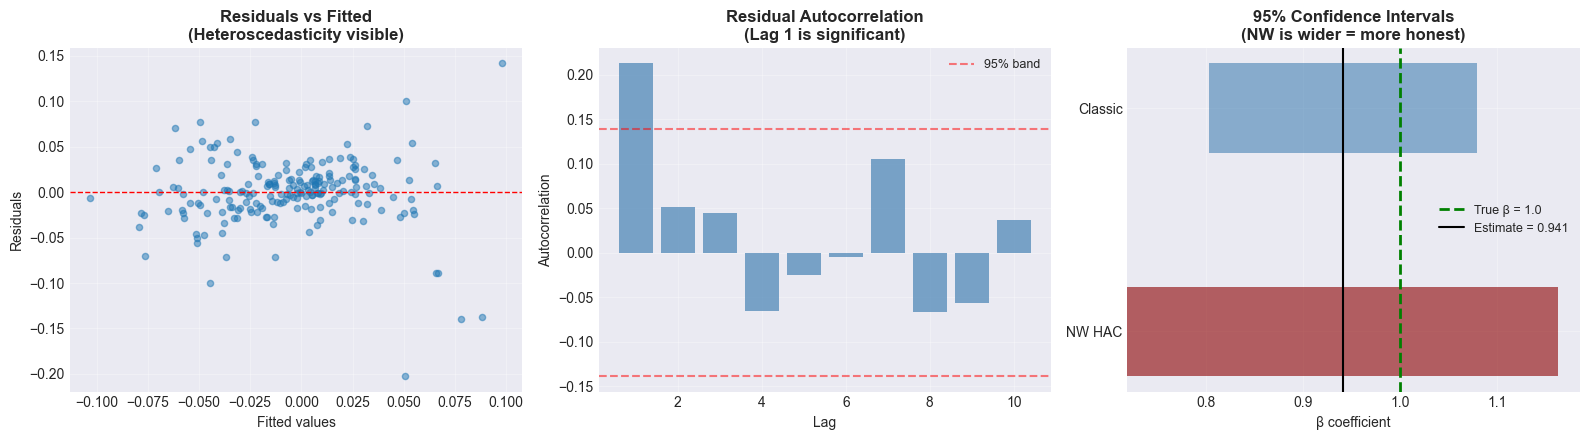


The Newey-West CI is wider because it honestly accounts for the
heteroscedasticity and autocorrelation that classic OLS ignores.


In [16]:
# ============================================================================
# Newey-West on a realistic simulated dataset
# ============================================================================

np.random.seed(42)
n_sim = 200

# Generate regressor
x_sim = np.random.randn(n_sim) * 0.04  # Scale like monthly factor returns

# Generate errors with heteroscedasticity + autocorrelation + fat tails
innovations = stats.t.rvs(df=5, size=n_sim)  # fat-tailed (t with 5 df)
errors = np.zeros(n_sim)
rho = 0.3  # AR(1) coefficient
for t in range(n_sim):
    if t == 0:
        errors[t] = innovations[t]
    else:
        errors[t] = rho * errors[t-1] + innovations[t]
# Add heteroscedasticity: variance proportional to |x|
errors = errors * (0.01 + 0.5 * np.abs(x_sim))

# True model: y = 0.001 + 1.0 * x + error
alpha_true, beta_true = 0.001, 1.0
y_sim = alpha_true + beta_true * x_sim + errors

# Fit OLS
X_sim = sm.add_constant(x_sim)
model_sim = sm.OLS(y_sim, X_sim).fit()

# Compute Newey-West with Andrews lag
lag_sim = int(np.floor(4 * (n_sim / 100) ** (2/9)))
model_nw = model_sim.get_robustcov_results(cov_type='HAC', maxlags=lag_sim)

print("REALISTIC SIMULATION: n=200, heteroscedastic + autocorrelated + fat-tailed errors")
print("=" * 75)
print(f"True parameters: α = {alpha_true}, β = {beta_true}")
print(f"Newey-West lag length (Andrews formula): L = {lag_sim}")

print(f"\n{'':15s}  {'Estimate':>10s}  {'Classic SE':>10s}  {'NW SE':>10s}  {'Classic t':>10s}  {'NW t':>10s}")
print("-" * 75)
for i, name in enumerate(['α (intercept)', 'β (slope)']):
    coef = model_sim.params[i]
    se_c = model_sim.bse[i]
    se_nw_val = model_nw.bse[i]
    t_c = model_sim.tvalues[i]
    t_nw = model_nw.tvalues[i]
    print(f"  {name:13s}  {coef:10.5f}  {se_c:10.5f}  {se_nw_val:10.5f}  {t_c:10.3f}  {t_nw:10.3f}")

print(f"\nClassic SE underestimates uncertainty:")
print(f"  SE(β) ratio (NW / Classic): {model_nw.bse[1] / model_sim.bse[1]:.2f}x")
print(f"\n  Classic p-value for β: {model_sim.pvalues[1]:.4f}")
print(f"  NW p-value for β:     {model_nw.pvalues[1]:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Plot 1: Residuals vs fitted
axes[0].scatter(model_sim.fittedvalues, model_sim.resid, alpha=0.5, s=20)
axes[0].axhline(0, color='red', linewidth=1, linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted\n(Heteroscedasticity visible)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Autocorrelation of residuals
acf_vals = [pd.Series(model_sim.resid).autocorr(lag=l) for l in range(1, 11)]
axes[1].bar(range(1, 11), acf_vals, color='steelblue', alpha=0.7)
axes[1].axhline(1.96/np.sqrt(n_sim), color='red', linestyle='--', alpha=0.5, label='95% band')
axes[1].axhline(-1.96/np.sqrt(n_sim), color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')
axes[1].set_title('Residual Autocorrelation\n(Lag 1 is significant)', fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: Confidence intervals comparison
coef_val = model_sim.params[1]
ci_classic = [coef_val - 1.96 * model_sim.bse[1], coef_val + 1.96 * model_sim.bse[1]]
ci_nw = [coef_val - 1.96 * model_nw.bse[1], coef_val + 1.96 * model_nw.bse[1]]
axes[2].barh(['NW HAC', 'Classic'], 
             [ci_nw[1] - ci_nw[0], ci_classic[1] - ci_classic[0]],
             left=[ci_nw[0], ci_classic[0]], height=0.4, alpha=0.6,
             color=['darkred', 'steelblue'])
axes[2].axvline(beta_true, color='green', linewidth=2, linestyle='--', label=f'True β = {beta_true}')
axes[2].axvline(coef_val, color='black', linewidth=1.5, label=f'Estimate = {coef_val:.3f}')
axes[2].set_xlabel('β coefficient')
axes[2].set_title('95% Confidence Intervals\n(NW is wider = more honest)', fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThe Newey-West CI is wider because it honestly accounts for the")
print("heteroscedasticity and autocorrelation that classic OLS ignores.")

---

## Section 9: Putting It All Together — From CLT to Newey-West to p-Values

### 9.1 The Grand Argument

We can now state the complete logical chain that justifies using the standard normal distribution for p-values in Fama-French regressions, even though the data is non-normal, heteroscedastic, and autocorrelated:

> **Step 1 (OLS coefficients are weighted averages).** The OLS estimator $\hat{\beta} = (X'X)^{-1}X'y$ is a linear function of $y_1, \ldots, y_n$. Since each $y_i = \beta x_i + \epsilon_i$, the estimator $\hat{\beta}$ is ultimately a weighted average of the error terms $\epsilon_i$.
>
> **Step 2 (CLT applies to weighted averages).** A generalized version of the CLT (Lindeberg-Feller or Eicker conditions) guarantees that $\hat{\beta}$ is asymptotically normal as $n \to \infty$, provided the errors are not too dependent or too heavy-tailed:
> $$\hat{\beta} \xrightarrow{d} \mathcal{N}\left(\beta, \; \text{Var}(\hat{\beta})\right)$$
> This holds **regardless of the distribution of $\epsilon_i$**: no normality needed.
>
> **Step 3 (Newey-West consistently estimates the variance).** Even though $\text{Var}(\hat{\beta})$ depends on the unknown error structure (heteroscedasticity + autocorrelation), the Newey-West estimator $\widehat{\text{Var}}_{NW}(\hat{\beta})$ converges to the true variance as $n \to \infty$.
>
> **Step 4 (Slutsky's theorem combines Steps 2–3).** The t-statistic
> $$t = \frac{\hat{\beta} - \beta_0}{\sqrt{\widehat{\text{Var}}_{NW}(\hat{\beta})}} \xrightarrow{d} \mathcal{N}(0, 1)$$
> under $H_0: \beta = \beta_0$. Therefore, p-values can be computed from the standard normal distribution.

### 9.2 What This Does NOT Require

- ❌ Normally distributed errors
- ❌ Constant error variance (homoscedasticity)
- ❌ Independent errors (no autocorrelation)
- ❌ Any specific parametric distribution for the errors

### 9.3 What This DOES Require

- ✅ A large enough sample ($n \geq 50$, ideally $\geq 100$ for financial data)
- ✅ Finite second moments ($E[\epsilon_i^2] < \infty$)
- ✅ Errors that are "not too dependent" (autocorrelation decays to zero as lag increases — satisfied by most financial return series)
- ✅ A consistent lag length $L$ (grows with $n$ but slower than $n$)

### 9.4 The Classification: Is This "Nonparametric"?

Technically, the approach is **semiparametric**:

| Aspect | Parametric or not? |
|--------|-------------------|
| Model for the mean ($E[y|x] = \alpha + \beta x$) | **Parametric** — we assume a linear model |
| Distribution of errors | **Nonparametric** — no distributional assumption |
| Variance estimation | **Nonparametric** — Newey-West uses the data directly (squared residuals and cross-products), not any parametric formula |
| Inference (p-values) | Based on **asymptotic normality** via CLT, not on any parametric distributional assumption |

In the finance literature, this is often loosely called "nonparametric" or "robust" inference. The key point: **the p-values do not depend on the error distribution**, only on the CLT.

MONTE CARLO: FALSE REJECTION RATES UNDER H₀ (β = 0)
Number of simulations:     2000
Sample size per sim:       150
Errors: t(5) innovations, AR(1) ρ=0.3, heteroscedastic

Nominal size (α):          5.0%
Classic OLS rejection rate: 18.4%
Newey-West rejection rate:  7.4%

INTERPRETATION:
  Classic OLS OVER-REJECTS: 18.4% >> 5%
    → Using classic SEs, you'd get too many false positives!
  Newey-West is close to 5%: the CLT + HAC correction works.

  This confirms the theory from Section 9.1:
  Newey-West + CLT → correctly calibrated p-values
  even with non-normal, heteroscedastic, autocorrelated data.


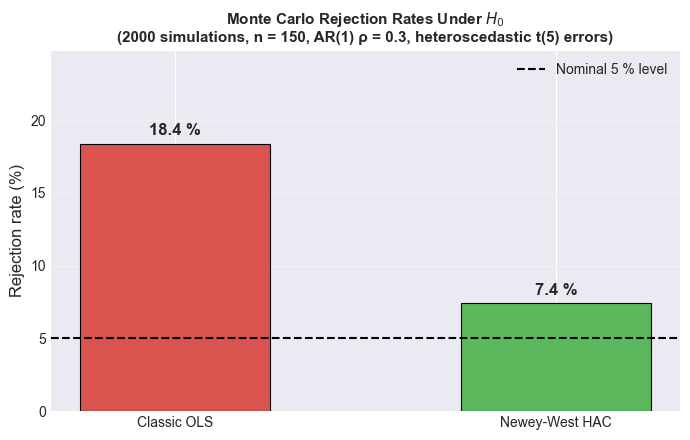


The bar chart confirms: Classic OLS over-rejects (red bar above the
dashed line), while Newey-West stays near the nominal 5 % level (green bar).


In [17]:
# ============================================================================
# Monte Carlo: Verify that Newey-West p-values are correctly calibrated
# under H₀, even with non-normal, heteroscedastic, autocorrelated errors
# ============================================================================
# If the theory is correct:
#   - Under H₀: β = 0, we should reject at 5% level exactly 5% of the time
#   - Classic OLS will over-reject (too many false positives)

np.random.seed(0)
num_mc = 2000
n_mc = 150  # Typical Fama-French sample size
reject_classic = 0
reject_nw = 0

for sim in range(num_mc):
    # Generate x (factor)
    x_mc = np.random.randn(n_mc) * 0.04
    
    # Generate non-normal, heteroscedastic, AR(1) errors
    innov = stats.t.rvs(df=5, size=n_mc)
    eps = np.zeros(n_mc)
    for t in range(n_mc):
        eps[t] = 0.3 * eps[t-1] + innov[t] if t > 0 else innov[t]
    eps = eps * (0.01 + 0.4 * np.abs(x_mc))  # heteroscedasticity
    
    # True β = 0 (null hypothesis is true)
    y_mc = 0.0 + 0.0 * x_mc + eps
    
    X_mc = sm.add_constant(x_mc)
    res_mc = sm.OLS(y_mc, X_mc).fit()
    lag_mc = int(np.floor(4 * (n_mc / 100) ** (2/9)))
    res_nw_mc = res_mc.get_robustcov_results(cov_type='HAC', maxlags=lag_mc)
    
    # Test β = 0 at 5% level (two-sided)
    if res_mc.pvalues[1] < 0.05:
        reject_classic += 1
    if res_nw_mc.pvalues[1] < 0.05:
        reject_nw += 1

print("MONTE CARLO: FALSE REJECTION RATES UNDER H₀ (β = 0)")
print("=" * 60)
print(f"Number of simulations:     {num_mc}")
print(f"Sample size per sim:       {n_mc}")
print(f"Errors: t(5) innovations, AR(1) ρ=0.3, heteroscedastic")
print(f"\nNominal size (α):          5.0%")
print(f"Classic OLS rejection rate: {reject_classic/num_mc*100:.1f}%")
print(f"Newey-West rejection rate:  {reject_nw/num_mc*100:.1f}%")
print(f"\nINTERPRETATION:")
if reject_classic / num_mc > 0.07:
    print(f"  Classic OLS OVER-REJECTS: {reject_classic/num_mc*100:.1f}% >> 5%")
    print(f"    → Using classic SEs, you'd get too many false positives!")
print(f"  Newey-West is close to 5%: the CLT + HAC correction works.")
print(f"\n  This confirms the theory from Section 9.1:")
print(f"  Newey-West + CLT → correctly calibrated p-values")
print(f"  even with non-normal, heteroscedastic, autocorrelated data.")

# ── Visualize the result: rejection-rate bar chart ──
rate_classic = reject_classic / num_mc * 100
rate_nw = reject_nw / num_mc * 100

fig, ax = plt.subplots(figsize=(7, 4.5))
bars = ax.bar(['Classic OLS', 'Newey-West HAC'], [rate_classic, rate_nw],
              color=['#d9534f', '#5cb85c'], width=0.5, edgecolor='black', linewidth=0.8)
ax.axhline(5, color='black', linestyle='--', linewidth=1.5, label='Nominal 5 % level')
ax.set_ylabel('Rejection rate (%)', fontsize=12)
ax.set_title('Monte Carlo Rejection Rates Under $H_0$\n'
             f'({num_mc} simulations, n = {n_mc}, AR(1) ρ = 0.3, heteroscedastic t(5) errors)',
             fontweight='bold', fontsize=11)
ax.set_ylim(0, max(rate_classic, rate_nw) * 1.35)

# Annotate bars
for bar, rate in zip(bars, [rate_classic, rate_nw]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.4,
            f'{rate:.1f} %', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nThe bar chart confirms: Classic OLS over-rejects (red bar above the")
print("dashed line), while Newey-West stays near the nominal 5 % level (green bar).")

---

## Section 10: Summary and Connection to the Fama-French Tutorials

### 10.1 What We've Shown

| Section | Key Result |
|---------|-----------|
| **1. Descriptive Stats** | Mean, variance, covariance computed by hand on 5 data points |
| **2. Population vs. Sample** | Standard error of the mean = $s / \sqrt{n}$ measures estimation uncertainty |
| **3. CLT** | Sample means are approximately normal for large $n$, regardless of the population distribution |
| **4. Hypothesis Testing & CLT** | t-statistics, p-values, confidence intervals, and why the normal approximation works |
| **5. Linear Regression & OLS** | Scalar and matrix derivations, residuals, and classic standard errors on a 5-observation regression |
| **6. Nonparametric Inference** | The sandwich formula: HC0 replaces scalar $\hat{\sigma}^2$ with observation-specific $\hat{\epsilon}_i^2$ |
| **7. Newey-West** | Extends HC0 by adding Bartlett-weighted cross-lag terms — handles autocorrelation too |
| **8. Realistic Simulation** | Newey-West gives wider (more honest) CIs when data has time-series structure |
| **9. Monte Carlo** | Classic OLS over-rejects under $H_0$; Newey-West maintains correct 5% size |

### 10.2 How This Connects to the Fama-French Notebooks

In the [3-Factor Tutorial](03_Fama_French_3Factor.ipynb):
- **Section 10** uses Newey-West standard errors for the Fama-French regression — now you understand *exactly* what that estimator computes and why it works.
- **Section 11** interprets t-statistics and p-values — now you know these are justified by the CLT, not by assuming normally distributed errors.
- The Andrews lag-selection formula $L = \lfloor 4(n/100)^{2/9} \rfloor$ is the same one derived here.

In the [Advanced Tutorial](04_Advanced_Factor_Models.ipynb):
- Every regression (5-factor, Carhart, rolling window) uses Newey-West HAC standard errors.
- The `run_ff_regression()` helper function computes the Newey-West estimator automatically.
- The Monte Carlo evidence here explains why those p-values are trustworthy despite the non-normality, fat tails, and volatility clustering present in real factor returns.

### 10.3 Quick Reference

**When to Use What:**

| Situation | Standard Errors | Why |
|-----------|----------------|-----|
| Cross-sectional data, homoscedastic | Classic OLS | All assumptions hold |
| Cross-sectional, possible heteroscedasticity | HC0/HC1/HC3 | Sandwich estimator handles non-constant variance |
| Time-series data (financial returns) | **Newey-West** | Handles both heteroscedasticity and autocorrelation |
| Any situation with $n \geq 100$ | Normal approximation for p-values | CLT guarantees asymptotic normality |

**The Newey-West Recipe:**

1. Fit OLS: $\hat{\beta} = (X'X)^{-1}X'y$
2. Compute residuals: $\hat{\epsilon}_i = y_i - \mathbf{x}_i'\hat{\beta}$
3. Choose lag $L = \lfloor 4(n/100)^{2/9}\rfloor$
4. Compute the meat: $\mathbf{M}_{NW} = \sum_i \hat{\epsilon}_i^2 \mathbf{x}_i\mathbf{x}_i' + \sum_{j=1}^{L} w_j \sum_{i>j} \hat{\epsilon}_i\hat{\epsilon}_{i-j}(\mathbf{x}_i\mathbf{x}_{i-j}' + \mathbf{x}_{i-j}\mathbf{x}_i')$
5. Sandwich: $\widehat{\text{Var}}_{NW} = (X'X)^{-1}\mathbf{M}_{NW}(X'X)^{-1}$
6. Standard errors: $\text{SE}(\hat{\beta}_j) = \sqrt{[\widehat{\text{Var}}_{NW}]_{jj}}$
7. t-statistics: $t_j = \hat{\beta}_j / \text{SE}(\hat{\beta}_j) \;\xrightarrow{d}\; \mathcal{N}(0,1)$ under $H_0$
8. p-values: $p = 2\Phi(-|t_j|)$ where $\Phi$ is the standard normal CDF

### 10.4 Next Steps

You are now ready to proceed to the [Fama-French 3-Factor Tutorial](03_Fama_French_3Factor.ipynb), where these concepts are applied to real market data. The statistical machinery developed here — CLT-based inference, sandwich estimators, Newey-West HAC — forms the foundation of all the inference in both tutorial notebooks.

---

## Exercises

Test your understanding of the statistical foundations developed in this notebook.

### Exercise 1: Hand Computation (Pencil & Paper)

Consider the dataset $x = [2, 5, 3, 8, 7]$ and $y = [4, 7, 5, 10, 9]$.

1. Compute the sample mean, variance, and standard deviation of $x$ and $y$.
2. Compute $\text{Cov}(x, y)$ and $\text{Corr}(x, y)$ by hand.
3. Set up the design matrix $\mathbf{X}$ (with a constant column) and compute $\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ using the normal equations. Verify your answer with numpy.

### Exercise 2: CLT in Action (Hands-On)

The CLT was demonstrated in Section 3.7 using an Exponential(1) distribution. Repeat the experiment with a **qualitatively different** non-normal distribution:

1. Draw samples of size $n = 5, 30, 100$ from a **Beta(0.5, 0.5)** distribution (use `np.random.beta(0.5, 0.5, size=n)`). This distribution is **bimodal** — most of the mass is near 0 and 1.
2. Compute 5 000 sample means for each $n$ and plot the histograms.
3. At what sample size does the distribution of $\bar{X}_n$ start looking approximately normal? Is this faster or slower than for Exponential(1)?
4. Why might a bimodal distribution converge faster than a heavily skewed one?

```python
# Starter code:
from scipy import stats
n_sims = 5000
mu_beta = 0.5  # E[Beta(0.5, 0.5)] = a/(a+b) = 0.5
var_beta = 0.5 * 0.5 / (1.0 * 2.0) # a*b / ((a+b)^2 * (a+b+1)) = 0.125
for n in [5, 30, 100]:
    means = np.array([np.random.beta(0.5, 0.5, size=n).mean() for _ in range(n_sims)])
    z = (means - mu_beta) / np.sqrt(var_beta / n)
    # ... plot histogram of z and overlay N(0, 1) density
```

### Exercise 3: Sandwich Estimator Comparison (Hands-On)

Using the 5-observation dataset from Section 5:

1. Artificially make the residuals heteroscedastic by multiplying $y$ by $[1, 1, 1, 3, 3]$ (i.e., inflate the last two observations). Refit by OLS.
2. Compute the classic SE, HC0 SE, and Newey-West SE for $\hat{\beta}_1$.
3. Which estimator changes the most? Why?

### Exercise 4: Monte Carlo — Varying the Autocorrelation (Challenge)

Extend the Monte Carlo simulation from Section 9:

1. Run the same experiment with autocorrelation coefficients $\rho \in \{0, 0.3, 0.6, 0.9\}$.
2. For each $\rho$, record the empirical rejection rate of the classic t-test and the Newey-West t-test at the 5% level.
3. Plot rejection rate vs. $\rho$ for both methods. At what $\rho$ does the classic test start seriously over-rejecting?

```python
# Starter code:
rho_values = [0.0, 0.3, 0.6, 0.9]
for rho in rho_values:
    # Generate AR(1) errors: e_t = rho * e_{t-1} + v_t
    # Fit OLS, compute classic and NW t-stats, check rejection at 5%
    pass
```

### Exercise 5: Why Does the Mixing CLT Matter? (Discussion)

1. Explain in your own words why the standard CLT (Lindeberg-Lévy) cannot be applied directly to time-series data.
2. What additional condition does the Mixing CLT require, and why is it satisfied for financial returns?
3. If the mixing condition were *not* satisfied (e.g., a random walk), what would go wrong with the Newey-West estimator?